In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matlab.engine

#=========================================================================================================
# Load dataset and check their dimensions
#=========================================================================================================

# Input and output dimensions
num_samples = 8000  # Number of samples for tarining dataset
num_variables = 10  # Total variables in the output data
num_timepoints = 13  # Number of time points

# Hyperparameters
num_epochs = 200
learning_rate = 1e-5

# Load the CSV files
input_path = 'train_input_data.csv'
output_path = 'train_output_data.csv'
patient_id_path = 'train_patient_ids.csv'

df_input = pd.read_csv(input_path, header=None)
df_output = pd.read_csv(output_path, header=None)
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert DataFrames to NumPy arrays
data_input = df_input.to_numpy()
data_output = df_output.to_numpy()
patient_ids = df_patient_ids.to_numpy().flatten()

num_clusters = data_input.shape[0] // num_samples

# Ensure data has correct shape
if data_input.shape != (num_samples * num_clusters, num_timepoints):
    raise ValueError(f"Input data must have {num_samples * num_clusters} rows and {num_timepoints} columns")

if data_output.shape != (num_samples * num_variables, num_timepoints):
    raise ValueError(f"Output data must have {num_samples * num_variables} rows and {num_timepoints} columns")

if patient_ids.shape != (num_samples,):
    raise ValueError(f"Patient IDs must have {num_samples} entries")

# Reshape data
reshaped_data_input = data_input.reshape(num_samples, num_clusters, num_timepoints)
reshaped_data_output = data_output.reshape(num_samples, num_variables, num_timepoints)

# Convert data to PyTorch tensors
input_data = torch.tensor(reshaped_data_input, dtype=torch.float32)
output_data = torch.tensor(reshaped_data_output, dtype=torch.float32)
patient_ids_tensor = torch.tensor(patient_ids, dtype=torch.long)

#=========================================================================================================
# Prepare for time point-wise training
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise = input_data.transpose(1, 2).reshape(-1, num_clusters)
output_data_timepointwise = output_data.transpose(1, 2).reshape(-1, num_variables)
patient_ids_timepointwise = patient_ids_tensor.repeat_interleave(num_timepoints)


In [2]:
# Load testing patients data

num_samples_test = 4000 # Number of samples for test dataset

# Load the CSV files
input_path_np = 'test_input_data.csv'  # sampled randomly from the clusters
output_path_np = 'test_output_data.csv'  # sampled randomly from the clusters
patient_id_path_np = 'test_patient_ids.csv'  # Path to the CSV file containing patient IDs

df_input_np = pd.read_csv(input_path_np, header=None)
df_output_np = pd.read_csv(output_path_np, header=None)
df_patient_ids_np = pd.read_csv(patient_id_path_np, header=None)

# Convert DataFrames to NumPy arrays
data_input_np = df_input_np.to_numpy()
data_output_np = df_output_np.to_numpy()
patient_ids_np = df_patient_ids_np.to_numpy().flatten()

# Ensure the input data has {num_samples_test * num_clusters} rows and {num_timepoints} columns
if data_input_np.shape != (num_samples_test * num_clusters, num_timepoints):
    raise ValueError(f"The input data must have {num_samples_test * num_clusters} rows and {num_timepoints} columns")

# Ensure the output data has {num_samples_test * num_variables} rows and {num_timepoints} columns
if data_output_np.shape != (num_samples_test * num_variables, num_timepoints):
    raise ValueError(f"The output data must have {num_samples_test * num_variables} rows and {num_timepoints} columns")

# Ensure the patient IDs data has {num_samples_test} entries
if patient_ids_np.shape != (num_samples_test,):
    raise ValueError(f"The patient IDs must have {num_samples_test} entries")

# Reshape the data to desired size
reshaped_data_input_np = data_input_np.reshape(num_samples_test, num_clusters, num_timepoints)
reshaped_data_output_np = data_output_np.reshape(num_samples_test, num_variables, num_timepoints)

# Convert the reshaped data to a PyTorch tensor
input_data_np = torch.tensor(reshaped_data_input_np, dtype=torch.float32)
output_data_np = torch.tensor(reshaped_data_output_np, dtype=torch.float32)
patient_ids_tensor_np = torch.tensor(patient_ids_np, dtype=torch.long)

# Print the shape of the tensors to verify
print(f"Input data shape: {input_data_np.shape}")
print(f"Output data shape: {output_data_np.shape}")
print(f"Patient IDs shape: {patient_ids_tensor_np.shape}")

#=========================================================================================================
# Prepare for time point-wise for testing
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_np_timepointwise = input_data_np.transpose(1, 2).reshape(-1, num_clusters)
output_data_np_timepointwise = output_data_np.transpose(1, 2).reshape(-1, num_variables)
patient_ids_np_timepointwise = patient_ids_tensor_np.repeat_interleave(num_timepoints)


Input data shape: torch.Size([4000, 15, 13])
Output data shape: torch.Size([4000, 10, 13])
Patient IDs shape: torch.Size([4000])


In [3]:

# Create datasets and dataloaders

train_dataset_timepointwise = TensorDataset(input_data_timepointwise, output_data_timepointwise, patient_ids_timepointwise)
test_dataset_timepointwise = TensorDataset(input_data_np_timepointwise, output_data_np_timepointwise, patient_ids_np_timepointwise)
train_loader = DataLoader(train_dataset_timepointwise, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset_timepointwise, batch_size=100, shuffle=False)


Epoch 1/200, Train Loss: 47.4274, Test Loss: 56.8140
Epoch 2/200, Train Loss: 38.5609, Test Loss: 41.7773
Epoch 3/200, Train Loss: 28.5646, Test Loss: 30.2432
Epoch 4/200, Train Loss: 24.6882, Test Loss: 26.7446
Epoch 5/200, Train Loss: 23.6649, Test Loss: 25.5423
Epoch 6/200, Train Loss: 22.7298, Test Loss: 24.5873
Epoch 7/200, Train Loss: 21.8853, Test Loss: 23.5175
Epoch 8/200, Train Loss: 20.8030, Test Loss: 22.4541
Epoch 9/200, Train Loss: 19.7414, Test Loss: 21.3192
Epoch 10/200, Train Loss: 18.9350, Test Loss: 20.2347
Epoch 11/200, Train Loss: 18.2593, Test Loss: 19.1747
Epoch 12/200, Train Loss: 17.5926, Test Loss: 18.3843
Epoch 13/200, Train Loss: 17.1491, Test Loss: 17.9151
Epoch 14/200, Train Loss: 16.7508, Test Loss: 17.2117
Epoch 15/200, Train Loss: 16.5746, Test Loss: 16.7827
Epoch 16/200, Train Loss: 16.2714, Test Loss: 16.6689
Epoch 17/200, Train Loss: 16.2133, Test Loss: 16.1796
Epoch 18/200, Train Loss: 16.1734, Test Loss: 16.1562
Epoch 19/200, Train Loss: 15.8974, Te

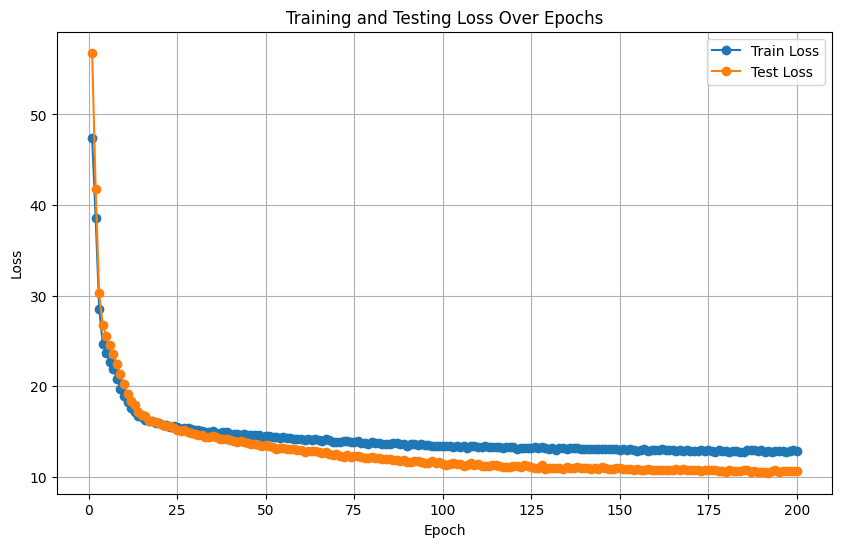

In [4]:
#=========================================================================================================
# Define the feedforward neural network
#=========================================================================================================
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
model = FeedforwardNN(num_clusters, num_variables)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#=========================================================================================================
# Train the model
#=========================================================================================================
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets, _ in train_loader:  # Patient IDs not used in this simple model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#=========================================================================================================
# Plot training and testing loss
#=========================================================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [6]:
import csv

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for reconstructed outputs (which will be used as input for the reverse VAE)
all_reconstructed_outputs = []

# Loop over each sample in the input data
with torch.no_grad():
    for i in range(num_samples):
        input_sample = input_data[i].to(device)  # Shape: (num_clusters, num_timepoints)
        
        # Initialize an empty list to store reconstructed outputs for each timepoint
        reconstructed_output_for_sample = []
        
        # Loop over each timepoint to get reconstructed output for each timepoint
        for t in range(num_timepoints):
            input_timepoint = input_sample[:, t].unsqueeze(0)  # Shape: (1, num_clusters)
            
            # Get the reconstructed output from the VAE
            recon = model(input_timepoint)
            
            # Append the reconstructed output to the list for this sample
            reconstructed_output_for_sample.append(recon.squeeze(0).cpu().numpy())  # Shape: (num_variables,)

        # Convert list of reconstructed outputs for this sample into an array and reshape to (num_variables, num_timepoints)
        reconstructed_output_for_sample = np.array(reconstructed_output_for_sample).T  # Shape: (num_variables, num_timepoints)
        
        # Append this sample's reconstructed output to the overall list
        all_reconstructed_outputs.append(reconstructed_output_for_sample)

# Convert the list of all reconstructed outputs to a numpy array with shape (num_samples, num_variables, num_timepoints)
all_reconstructed_outputs = np.array(all_reconstructed_outputs)

# Reshape to (num_samples * num_variables, num_timepoints) to match the expected format
all_reconstructed_outputs = all_reconstructed_outputs.reshape(num_samples * num_variables, num_timepoints)

# Save the reconstructed outputs to a CSV file
output_filename = 'vae_reconstructed_outputs.csv'
with open(output_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(all_reconstructed_outputs)

print(f'Reconstructed outputs saved to {output_filename}')


Reconstructed outputs saved to vae_reconstructed_outputs.csv


In [7]:
import csv

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for reconstructed outputs (which will be used as input for the reverse VAE)
all_reconstructed_outputs = []

# Loop over each sample in the input data
with torch.no_grad():
    for i in range(num_samples_test):
        input_sample = input_data_np[i].to(device)  # Shape: (num_clusters, num_timepoints)
        
        # Initialize an empty list to store reconstructed outputs for each timepoint
        reconstructed_output_for_sample = []
        
        # Loop over each timepoint to get reconstructed output for each timepoint
        for t in range(num_timepoints):
            input_timepoint = input_sample[:, t].unsqueeze(0)  # Shape: (1, num_clusters)
            
            # Get the reconstructed output from the VAE
            recon = model(input_timepoint)
            
            # Append the reconstructed output to the list for this sample
            reconstructed_output_for_sample.append(recon.squeeze(0).cpu().numpy())  # Shape: (num_variables,)

        # Convert list of reconstructed outputs for this sample into an array and reshape to (num_variables, num_timepoints)
        reconstructed_output_for_sample = np.array(reconstructed_output_for_sample).T  # Shape: (num_variables, num_timepoints)
        
        # Append this sample's reconstructed output to the overall list
        all_reconstructed_outputs.append(reconstructed_output_for_sample)

# Convert the list of all reconstructed outputs to a numpy array with shape (num_samples, num_variables, num_timepoints)
all_reconstructed_outputs = np.array(all_reconstructed_outputs)

# Reshape to (num_samples * num_variables, num_timepoints) to match the expected format
all_reconstructed_outputs = all_reconstructed_outputs.reshape(num_samples_test * num_variables, num_timepoints)

# Save the reconstructed outputs to a CSV file
output_filename = 'vae_reconstructed_outputs_test.csv'
with open(output_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(all_reconstructed_outputs)

print(f'Reconstructed outputs for test set saved to {output_filename}')


Reconstructed outputs for test set saved to vae_reconstructed_outputs_test.csv


In [8]:
# Load the mean data from CSV
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load patient IDs from the CSV file (they are in a single row)
patient_id_path = 'train_patient_ids.csv'
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert the row into a list
patient_ids_list = df_patient_ids.iloc[0].tolist()  # Extracting the first row and converting to a list

# Prepare a list to collect the filtered data
filtered_patient_cluster_data = []

# Loop over each patient ID and filter the data
for patient in patient_ids_list:
    # Select rows for the current patient
    patient_data = df_mean_data[df_mean_data.iloc[:, 0] == f'Patient_{patient}']  # first column is patient info
    
    # Extract mean values for all clusters and timepoints (ignoring patient and cluster columns)
    mean_values = patient_data.iloc[:, 2:].values  # Adjust to capture only timepoint data
    
    filtered_patient_cluster_data.append(mean_values)

# Convert the list to a 3D numpy array
filtered_patient_cluster_data = np.array(filtered_patient_cluster_data)

# Reshape to (num_samples * num_clusters, num_timepoints) format
reshaped_data = filtered_patient_cluster_data.reshape(filtered_patient_cluster_data.shape[0] * filtered_patient_cluster_data.shape[1], filtered_patient_cluster_data.shape[2])

# Save the reshaped data to a CSV file
output_filename = 'sampled_mean_cluster_data.csv'
np.savetxt(output_filename, reshaped_data, delimiter=',')
print(f'Mean cluster data saved to {output_filename}')


Mean cluster data saved to sampled_mean_cluster_data.csv


In [9]:
# Load the mean data from CSV
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load patient IDs from the CSV file (they are in a single row)
patient_id_path = 'test_patient_ids.csv'
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert the row into a list
patient_ids_list = df_patient_ids.iloc[0].tolist()  # Extracting the first row and converting to a list

# Prepare a list to collect the filtered data
filtered_patient_cluster_data = []

# Loop over each patient ID and filter the data
for patient in patient_ids_list:
    # Select rows for the current patient
    patient_data = df_mean_data[df_mean_data.iloc[:, 0] == f'Patient_{patient}']  # first column is patient info
    
    # Extract mean values for all clusters and timepoints (ignoring patient and cluster columns)
    mean_values = patient_data.iloc[:, 2:].values  # Adjust to capture only timepoint data
    
    filtered_patient_cluster_data.append(mean_values)

# Convert the list to a 3D numpy array
filtered_patient_cluster_data = np.array(filtered_patient_cluster_data)

# Reshape to (num_samples * num_clusters, num_timepoints) format
reshaped_data = filtered_patient_cluster_data.reshape(filtered_patient_cluster_data.shape[0] * filtered_patient_cluster_data.shape[1], filtered_patient_cluster_data.shape[2])

# Save the reshaped data to a CSV file
output_filename = 'sampled_mean_cluster_data_test.csv'
np.savetxt(output_filename, reshaped_data, delimiter=',')
print(f'Mean cluster data for test set saved to {output_filename}')


Mean cluster data for test set saved to sampled_mean_cluster_data_test.csv


In [10]:
# =====================================================================================================
# Data preparation for Reverse VAE model
# =====================================================================================================

# Define the paths for input and output data (with 'reverse' context)
input_path_reverse = 'vae_reconstructed_outputs.csv'  # Input path for VAE reconstructed outputs
output_path_reverse = 'sampled_mean_cluster_data.csv'  # Output path for sampled mean cluster data

# Load the CSV files
df_input_reverse = pd.read_csv(input_path_reverse, header=None)
df_output_reverse = pd.read_csv(output_path_reverse, header=None)

# Convert DataFrames to NumPy arrays
input_array_reverse = df_input_reverse.to_numpy()
output_array_reverse = df_output_reverse.to_numpy()

# Reshape data for Reverse VAE model
reshaped_input_reverse = input_array_reverse.reshape(num_samples, num_variables, num_timepoints)
reshaped_output_reverse = output_array_reverse.reshape(num_samples, num_clusters, num_timepoints)

# Convert data to PyTorch tensors
input_tensor_reverse = torch.tensor(reshaped_input_reverse, dtype=torch.float32)
output_tensor_reverse = torch.tensor(reshaped_output_reverse, dtype=torch.float32)

#=========================================================================================================
# Prepare for time point-wise training (reverse)
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise_reverse = input_tensor_reverse.transpose(1, 2).reshape(-1, num_variables)
output_data_timepointwise_reverse = output_tensor_reverse.transpose(1, 2).reshape(-1, num_clusters)


input_data_reverse = input_data_timepointwise_reverse  # (Mathematical model variables)
output_data_reverse = output_data_timepointwise_reverse  # (Gene expression values)



In [11]:
# =====================================================================================================
# Data preparation for Reverse VAE model
# =====================================================================================================

# Define the paths for input and output data (with 'reverse' context)
input_path_reverse_test = 'vae_reconstructed_outputs_test.csv'  # Input path for VAE reconstructed outputs
output_path_reverse_test = 'sampled_mean_cluster_data_test.csv'  # Output path for sampled mean cluster data

# Load the CSV files
df_input_reverse_test = pd.read_csv(input_path_reverse_test, header=None)
df_output_reverse_test = pd.read_csv(output_path_reverse_test, header=None)

# Convert DataFrames to NumPy arrays
input_array_reverse_test = df_input_reverse_test.to_numpy()
output_array_reverse_test = df_output_reverse_test.to_numpy()

# Reshape data for Reverse VAE model
reshaped_input_reverse_test = input_array_reverse_test.reshape(num_samples_test, num_variables, num_timepoints)
reshaped_output_reverse_test = output_array_reverse_test.reshape(num_samples_test, num_clusters, num_timepoints)

# Convert data to PyTorch tensors
input_tensor_reverse_test = torch.tensor(reshaped_input_reverse_test, dtype=torch.float32)
output_tensor_reverse_test = torch.tensor(reshaped_output_reverse_test, dtype=torch.float32)

#=========================================================================================================
# Prepare for time point-wise training (reverse)
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise_reverse_test = input_tensor_reverse_test.transpose(1, 2).reshape(-1, num_variables)
output_data_timepointwise_reverse_test = output_tensor_reverse_test.transpose(1, 2).reshape(-1, num_clusters)


input_data_reverse_test = input_data_timepointwise_reverse_test  # (Mathematical model variables)
output_data_reverse_test = output_data_timepointwise_reverse_test # (Gene expression values)



In [12]:
# Create datasets and dataloaders for reverse mapping
train_dataset_reverse = TensorDataset(input_data_reverse, output_data_reverse, patient_ids_timepointwise)
test_dataset_reverse = TensorDataset(input_data_reverse_test, output_data_reverse_test, patient_ids_np_timepointwise)

# Create DataLoaders for the training and testing datasets
train_loader_reverse = DataLoader(train_dataset_reverse, batch_size=100, shuffle=True)
test_loader_reverse = DataLoader(test_dataset_reverse, batch_size=100, shuffle=False)

Epoch 1/200, Train Loss: 1.2939, Test Loss: 0.7833
Epoch 2/200, Train Loss: 0.8250, Test Loss: 0.4699
Epoch 3/200, Train Loss: 0.6310, Test Loss: 0.3285
Epoch 4/200, Train Loss: 0.5502, Test Loss: 0.2800
Epoch 5/200, Train Loss: 0.5148, Test Loss: 0.2565
Epoch 6/200, Train Loss: 0.4884, Test Loss: 0.2383
Epoch 7/200, Train Loss: 0.4694, Test Loss: 0.2194
Epoch 8/200, Train Loss: 0.4548, Test Loss: 0.2155
Epoch 9/200, Train Loss: 0.4464, Test Loss: 0.2077
Epoch 10/200, Train Loss: 0.4405, Test Loss: 0.2033
Epoch 11/200, Train Loss: 0.4358, Test Loss: 0.2008
Epoch 12/200, Train Loss: 0.4307, Test Loss: 0.1935
Epoch 13/200, Train Loss: 0.4291, Test Loss: 0.1917
Epoch 14/200, Train Loss: 0.4256, Test Loss: 0.1896
Epoch 15/200, Train Loss: 0.4234, Test Loss: 0.1882
Epoch 16/200, Train Loss: 0.4194, Test Loss: 0.1821
Epoch 17/200, Train Loss: 0.4178, Test Loss: 0.1834
Epoch 18/200, Train Loss: 0.4174, Test Loss: 0.1751
Epoch 19/200, Train Loss: 0.4154, Test Loss: 0.1775
Epoch 20/200, Train L

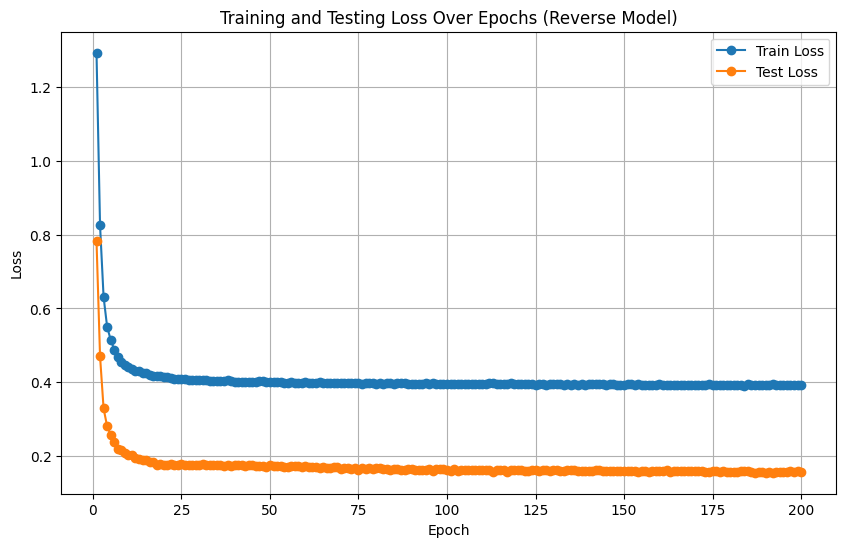

In [13]:
#=========================================================================================================
# Define the feedforward neural network for reverse
#=========================================================================================================
class FeedforwardNNreverse(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNNreverse, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize reverse model, loss function, and optimizer
reverse_model = FeedforwardNNreverse(num_variables, num_clusters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(reverse_model.parameters(), lr=learning_rate)

#=========================================================================================================
# Train the reverse model
#=========================================================================================================
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    reverse_model.train()
    train_loss = 0.0
    for inputs, targets, _ in train_loader_reverse:  # Patient IDs not used
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = reverse_model(inputs)  # Use reverse model
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader_reverse.dataset)
    train_losses.append(train_loss)
    
    # Testing phase
    reverse_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in test_loader_reverse:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = reverse_model(inputs)  # Use reverse model
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader_reverse.dataset)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#=========================================================================================================
# Plot training and testing loss
#=========================================================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs (Reverse Model)')
plt.legend()
plt.grid()
plt.show()


In [15]:
# =========================================================================================================
# Extract standard deviation data for each patient, cluster, and timepoint
#==========================================================================================================

# Load the gene standard deviations data 
std_data_path = 'input_data_std.csv'
df_std_data = pd.read_csv(std_data_path)

# Initialize the tensor for gene variances per patient, cluster, and timepoint
gene_variances_per_cluster_timepoint = torch.zeros(num_samples, num_clusters, num_timepoints)

# Populate the tensor using the loaded std data from CSV
for patient_idx in range(num_samples):
    # Get the patient ID for the current sample
    patient_id = patient_ids[patient_idx]  # This is the patient index for the current sample
    patient_label = f"Patient_{patient_id}"  # Construct the patient label
    for cluster_idx in range(num_clusters):
        # Construct labels to filter std data for the specific patient and cluster
        cluster_label = f"Cluster_{cluster_idx + 1}"
        
        # Filter the standard deviation data for the current patient and cluster
        filtered_data = df_std_data[(df_std_data['Patient'] == patient_label) & (df_std_data['Cluster'] == cluster_label)]

        # Extract timepoint values
        timepoint_values = filtered_data.iloc[0, 2:].values  # first two columns are 'Patient' and 'Cluster'
        timepoint_values = pd.to_numeric(timepoint_values)
        
        # Assign to tensor
        gene_variances_per_cluster_timepoint[patient_idx, cluster_idx, :] = torch.tensor(timepoint_values, dtype=torch.float32)

# Move tensor to GPU if available
gene_variances_per_cluster_timepoint = gene_variances_per_cluster_timepoint.to('cuda' if torch.cuda.is_available() else 'cpu')

# Print the shape of the tensors to verify
print(f"Gene STD data shape: {gene_variances_per_cluster_timepoint.shape}")

# Timepoint wise shape
gene_std_data_timepointwise = gene_variances_per_cluster_timepoint.transpose(1, 2).reshape(-1, num_clusters)

# Print the shape of the tensors to verify
print(f"Gene STD data shape timepointwise: {gene_std_data_timepointwise.shape}")

Gene STD data shape: torch.Size([8000, 15, 13])
Gene STD data shape timepointwise: torch.Size([104000, 15])


In [17]:
def original_vs_predicted(model, mean_data, output_data_np, patient_id, patient_ids_tensor_np, timepoint):
    """
    Plot the original data vs. predicted data for a specific patient and timepoint.

    Parameters:
    - model: Trained PyTorch model.
    - mean_data (Tensor): Mean data for input clusters at the given timepoint.
    - output_data_np (Tensor): Tensor containing the true output data for all patients.
    - patient_id (int): ID of the patient to evaluate.
    - patient_ids_tensor_np (Tensor): Tensor of patient IDs corresponding to the output data.
    - timepoint (int): The specific timepoint for evaluation (Python index).

    Returns:
    - None: Displays the plot comparing original and predicted data.
    """
    # Ensure mean data has correct shape
    mean_data = mean_data.unsqueeze(0)  # Add batch dimension: Shape [1, num_clusters]

    # Get true data for the patient and timepoint
    patient_indices = (patient_ids_tensor_np == patient_id).nonzero(as_tuple=True)[0]
    if patient_indices.numel() == 0:
        raise ValueError(f"Patient ID {patient_id} not found in the test data.")
    
    # Get the true output for the specified patient and timepoint
    true_output = output_data_np[patient_indices[0], :, timepoint].squeeze(0)  # Shape [num_variables]

    # Predict using the model
    model.eval()
    with torch.no_grad():
        predicted_output = model(mean_data).squeeze(0)  # Shape [num_variables]

    # Convert to NumPy for plotting
    true_output_np = true_output.numpy().flatten()
    predicted_output_np = predicted_output.numpy().flatten()

    return mean_data, predicted_output_np, true_output_np

In [18]:
# =========================================================================================================
#  Timepoint names and variable names
# =========================================================================================================

timepoint_names = [ 'Before Surgery', '5 Minutes', '30 Minutes', '60 Minutes', 
    '120 Minutes', '1 Day', '2 Days', '3 Days', 
    '4 Days', '10 Days', '3 Months', '6 Months', '1 Year' ]


variable_names = ['TNF', 'JAK', 'STAT3', 'SOCS3', 'ECM', 
                  'IE', 'GF', 'Q', 'P', 'R']


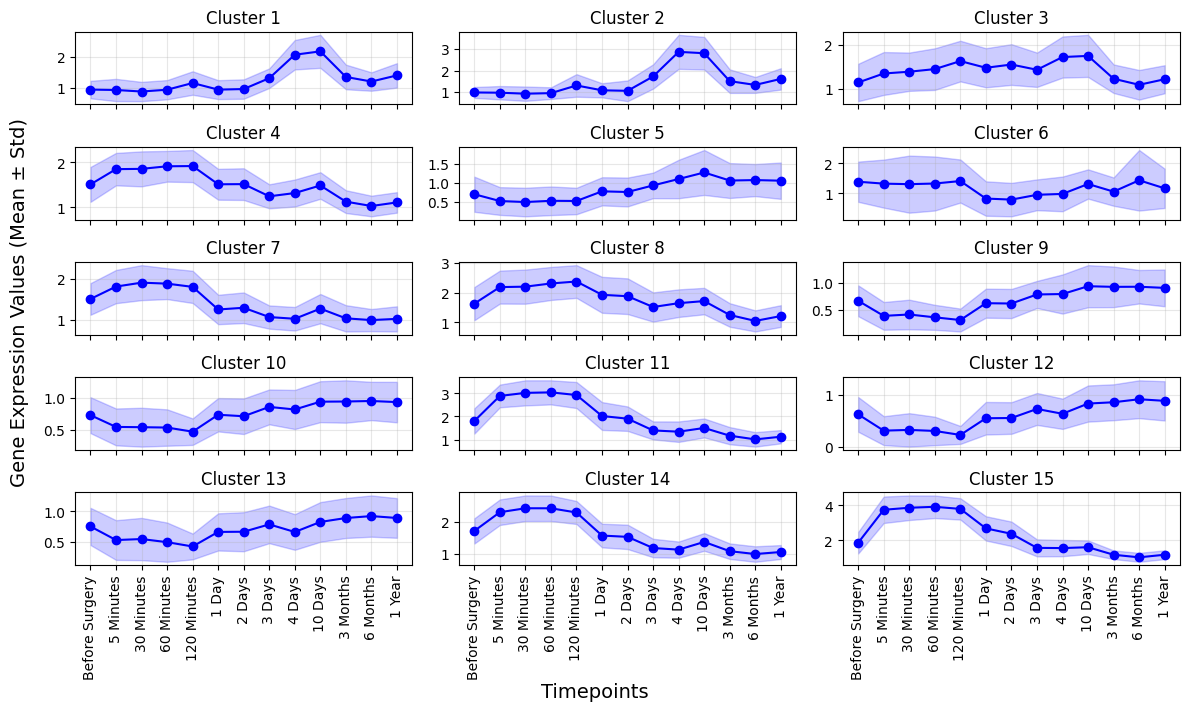

In [45]:
# ================================================================================================
# Plot the mean and standard deviation of gene values: original data with filled regions
# ================================================================================================

# Construct patient and cluster labels to filter mean and std data for the specific patient and timepoint
patient_id = 10
patient_label = f"Patient_{patient_id}"

# Load mean data
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load standard deviation data
std_data_path = 'input_data_std.csv'
df_std_data = pd.read_csv(std_data_path)

# Define the timepoint column name based on the timepoint index
num_timepoints = 13
timepoint_values = np.arange(1, num_timepoints + 1)

# Filter the data to get only rows that match the specified patient
patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

# Extract mean and std data vectors for the specified timepoints across all clusters
mean_data = patient_mean_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
std_data = patient_std_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)

# Create a 4 by 4 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(12, 7), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot data for each cluster
for idx in range(mean_data.shape[0]):  # Loop through clusters
    # Plot mean curve
    axes[idx].plot(timepoint_names, mean_data[idx, :], '-o', label=f"Cluster {idx + 1}", color='blue')
    
    # Add shaded region for std deviation
    axes[idx].fill_between(
        timepoint_names,
        mean_data[idx, :] - std_data[idx, :],
        mean_data[idx, :] + std_data[idx, :],
        color='blue',
        alpha=0.2
    )
    
    # Customize subplot
    axes[idx].set_xticks(timepoint_names)  # Set x-axis ticks with the timepoint names 
    axes[idx].set_xticklabels(timepoint_names, rotation=90)  # Rotate tick labels
    axes[idx].set_title(f"Cluster {idx + 1}", fontsize=12)
    axes[idx].grid(alpha=0.3)
    if idx == 6:  # Label only the first subplot in each row
        axes[idx].set_ylabel("Gene Expression Values (Mean ± Std) \n", fontsize=14)

# Set the x-axis labels across all subplots
fig.text(0.5, -0.004, 'Timepoints', ha='center', fontsize=14)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


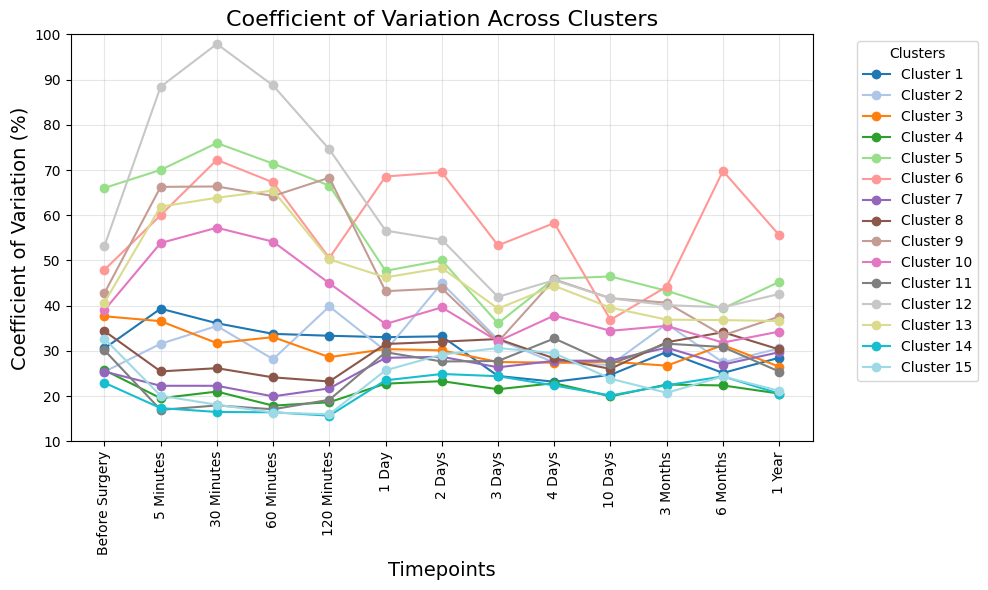

In [20]:
# ================================================================================================
# Compute Coefficient of Variation (CV) and compare across clusters
# ================================================================================================

# Compute CV for each cluster at each timepoint
cv_data = (std_data / mean_data) * 100  # Shape: (num_clusters, num_timepoints)

# Generate a distinct color palette using Matplotlib's colormap
num_clusters = cv_data.shape[0]
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))  # Tab20 colormap

# Plot CV for each cluster
fig, ax = plt.subplots(figsize=(10, 6))

for idx in range(num_clusters):  # Loop through clusters
    ax.plot(
        timepoint_names,
        cv_data[idx, :],
        '-o',
        label=f"Cluster {idx + 1}",
        color=colors[idx]
    )

# Customize plot
ax.set_title("Coefficient of Variation Across Clusters", fontsize=16)
ax.set_xlabel("Timepoints", fontsize=14)
ax.set_ylabel("Coefficient of Variation (%)", fontsize=14)
ax.grid(alpha=0.3)
ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Set y-axis limits
ax.set_ylim(10, 100)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [21]:
# Function to handle MATLAB ODE solving
def matlab_solve_ode(patient_id, timepoint, initial_values):
    """Call MATLAB engine to solve ODE."""
    eng = matlab.engine.start_matlab()
    try:
        matlab_initial_values = matlab.double(initial_values)
        next_timepoint_data = eng.calculate_time_series_data(patient_id, timepoint, matlab_initial_values)
        next_timepoint_data_list = [float(item[0]) for item in next_timepoint_data]
    finally:
        eng.quit()
    return next_timepoint_data_list

# Function to predict gene expression using Reverse VAE
def predict_gene_expression(reverse_model, simu_data):
    """Predict gene expression values using Reverse VAE."""
    with torch.no_grad():
        predicted_gene_expression = reverse_model(simu_data)
    return predicted_gene_expression.cpu().numpy().flatten()

In [22]:
# This is to predict all the timepoints after the given initial timepoint

# Function to handle MATLAB ODE solving
def matlab_solve_ode_all(patient_id, timepoint, initial_values):
    """Call MATLAB engine to solve ODE."""
    eng = matlab.engine.start_matlab()
    try:
        matlab_initial_values = matlab.double(initial_values)
        next_timepoint_data = eng.calculate_time_series_data(patient_id, timepoint, matlab_initial_values)
    finally:
        eng.quit()
    return next_timepoint_data

In [23]:
def process_timepoints(patient_id, initial_timepoint, num_patient_samples):
    """
    Process timepoints for a given patient and initial timepoint.

    Parameters:
        patient_id (int): The ID of the patient to process.
        initial_timepoint (int): The starting timepoint for processing.
        num_patient_samples (int): The number of patient samples to evaluate. Default is 50.

    Returns:
        dict: Mean and standard deviation data for all clusters across timepoints.
        list: Results containing patient ID, timepoint, and predicted expression.
    """
    print("===========================================================")
    print(f"\n--> Initial input details: Patient {patient_id} | Timepoint {timepoint_names[initial_timepoint]}")

    # Define the range of timepoints to process
    timepoint_values = range(initial_timepoint + 1, 13)  # From initial_timepoint+1 to 12

    # Get all indices for the given patient
    patient_indices = (patient_ids_tensor_np == patient_id).nonzero(as_tuple=True)[0]

    if len(patient_indices) == 0:
        raise ValueError(f"No data found for patient ID {patient_id}")

    # Select the first few indices for the patient
    patient_indices = patient_indices[:num_patient_samples]

    # Prepare to store results for plotting and CSV
    all_timepoints_mean = {cluster_idx: [] for cluster_idx in range(num_clusters)}  # For each cluster
    all_timepoints_std = {cluster_idx: [] for cluster_idx in range(num_clusters)}  # For each cluster
    results_list = []

    # Iterate over each timepoint
    for timepoint in timepoint_values:
        print(f"\n=====> Processing timepoint {timepoint_names[timepoint]}")

        # Initialize storage for gene values at this timepoint
        gene_values_for_timepoint = {cluster_idx: [] for cluster_idx in range(num_clusters)}

        # Process each occurrence of the patient ID at this timepoint
        for patient_idx in patient_indices:
            try:
                print(f"Processing patient ID {patient_id} at index {patient_idx}")

                # Access the relevant data for the current patient and timepoint
                gene_data = input_data_np[patient_idx, :, timepoint]

                # Plot original vs predicted values
                gene_data, predicted_output_np, true_output_np = original_vs_predicted(
                    model=model,
                    mean_data=gene_data,
                    output_data_np=output_data_np,
                    patient_id=patient_id,
                    patient_ids_tensor_np=patient_ids_tensor_np,
                    timepoint=timepoint
                )

                # Use the last predicted values as initial values for the mathematical model
                initial_values = predicted_output_np.tolist()

                # Solve ODE using MATLAB
                next_timepoint_data = matlab_solve_ode_all(patient_id, initial_timepoint, initial_values)

                # Ensure next_timepoint_data is a NumPy array
                next_timepoint_data = np.array(next_timepoint_data)

                # Extract the relevant column from the MATLAB matrix
                column_data = next_timepoint_data[:, timepoint - (initial_timepoint + 1)]
                next_timepoint_data_list = column_data.tolist()

                # Predict the next time point gene expression data using Reverse VAE
                simu_data = torch.tensor(next_timepoint_data_list, dtype=torch.float).unsqueeze(0).to(device)
                predicted_gene_expression_np = predict_gene_expression(reverse_model, simu_data)

                # Save the predicted data to results list
                results_list.append({
                    "Patient_ID": patient_id,
                    "Timepoint": timepoint + 1,
                    "Predicted_Expression": list(predicted_gene_expression_np)
                })

                # Collect data for plotting
                for cluster_idx in range(num_clusters):
                    gene_values_for_timepoint[cluster_idx].append(predicted_gene_expression_np[cluster_idx])

            except Exception as e:
                print(f"Error processing patient ID {patient_id} at index {patient_idx}: {e}")
                continue  # Skip to the next patient index

        # Compute mean and std for the timepoint for each cluster
        for cluster_idx in range(num_clusters):
            timepoint_gene_values = np.array(gene_values_for_timepoint[cluster_idx])  
            mean_per_gene = timepoint_gene_values.mean()
            std_per_gene = timepoint_gene_values.std()
            all_timepoints_mean[cluster_idx].append(mean_per_gene)
            all_timepoints_std[cluster_idx].append(std_per_gene)

    # Convert means and stds to numpy arrays
    all_timepoints_mean_np = np.array([all_timepoints_mean[cluster_idx] for cluster_idx in range(num_clusters)])
    all_timepoints_std_np = np.array([all_timepoints_std[cluster_idx] for cluster_idx in range(num_clusters)])

    return {
        "mean": all_timepoints_mean_np,
        "std": all_timepoints_std_np
    }, results_list



In [24]:
# Define the range of initial timepoints
initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
patient_id = 6
num_patient_samples = 50

# Initialize a dictionary to store data for each initial timepoint
stored_data_6 = {}

for _, initial_timepoint in enumerate(initial_timepoints):
    # Process data for the specific initial timepoint
    data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

    # Store the processed data and results in the dictionary
    stored_data_6[initial_timepoint] = {
        "data": data,
        "results": results
    }

# # Now `stored_data` contains data for all initial timepoints
# # Example: Accessing data for initial_timepoint 0
# print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# print(f"Results for initial timepoint 0: {stored_data[0]['results']}")



--> Initial input details: Patient 6 | Timepoint Before Surgery

=====> Processing timepoint 5 Minutes
Processing patient ID 6 at index 0
Processing patient ID 6 at index 11
Processing patient ID 6 at index 13
Processing patient ID 6 at index 15
Processing patient ID 6 at index 20
Processing patient ID 6 at index 22
Processing patient ID 6 at index 23
Processing patient ID 6 at index 24
Processing patient ID 6 at index 32
Processing patient ID 6 at index 34
Processing patient ID 6 at index 38
Processing patient ID 6 at index 43
Processing patient ID 6 at index 44
Processing patient ID 6 at index 53
Processing patient ID 6 at index 57
Processing patient ID 6 at index 63
Processing patient ID 6 at index 64
Processing patient ID 6 at index 80
Processing patient ID 6 at index 84
Processing patient ID 6 at index 89
Processing patient ID 6 at index 90
Processing patient ID 6 at index 91
Processing patient ID 6 at index 92
Processing patient ID 6 at index 95
Processing patient ID 6 at index 

In [25]:
# Define the range of initial timepoints
initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
patient_id = 5
num_patient_samples = 50

# Initialize a dictionary to store data for each initial timepoint
stored_data_5 = {}

for _, initial_timepoint in enumerate(initial_timepoints):
    # Process data for the specific initial timepoint
    data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

    # Store the processed data and results in the dictionary
    stored_data_5[initial_timepoint] = {
        "data": data,
        "results": results
    }

# # Now `stored_data` contains data for all initial timepoints
# # Example: Accessing data for initial_timepoint 0
# print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# print(f"Results for initial timepoint 0: {stored_data[0]['results']}")



--> Initial input details: Patient 5 | Timepoint Before Surgery

=====> Processing timepoint 5 Minutes
Processing patient ID 5 at index 3
Processing patient ID 5 at index 5
Processing patient ID 5 at index 12
Processing patient ID 5 at index 14
Processing patient ID 5 at index 16
Processing patient ID 5 at index 17
Processing patient ID 5 at index 19
Processing patient ID 5 at index 21
Processing patient ID 5 at index 36
Processing patient ID 5 at index 39
Processing patient ID 5 at index 40
Processing patient ID 5 at index 45
Processing patient ID 5 at index 46
Processing patient ID 5 at index 48
Processing patient ID 5 at index 49
Processing patient ID 5 at index 52
Processing patient ID 5 at index 55
Processing patient ID 5 at index 59
Processing patient ID 5 at index 62
Processing patient ID 5 at index 69
Processing patient ID 5 at index 71
Processing patient ID 5 at index 72
Processing patient ID 5 at index 74
Processing patient ID 5 at index 82
Processing patient ID 5 at index 9

In [26]:
# Define the range of initial timepoints
initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
patient_id = 10
num_patient_samples = 50

# Initialize a dictionary to store data for each initial timepoint
stored_data_10 = {}

for _, initial_timepoint in enumerate(initial_timepoints):
    # Process data for the specific initial timepoint
    data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

    # Store the processed data and results in the dictionary
    stored_data_10[initial_timepoint] = {
        "data": data,
        "results": results
    }

# # Now `stored_data` contains data for all initial timepoints
# # Example: Accessing data for initial_timepoint 0
# print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# print(f"Results for initial timepoint 0: {stored_data[0]['results']}")



--> Initial input details: Patient 10 | Timepoint Before Surgery

=====> Processing timepoint 5 Minutes
Processing patient ID 10 at index 6
Processing patient ID 10 at index 8
Processing patient ID 10 at index 10
Processing patient ID 10 at index 25
Processing patient ID 10 at index 28
Processing patient ID 10 at index 30
Processing patient ID 10 at index 31
Processing patient ID 10 at index 37
Processing patient ID 10 at index 41
Processing patient ID 10 at index 42
Processing patient ID 10 at index 47
Processing patient ID 10 at index 50
Processing patient ID 10 at index 51
Processing patient ID 10 at index 56
Processing patient ID 10 at index 58
Processing patient ID 10 at index 65
Processing patient ID 10 at index 66
Processing patient ID 10 at index 67
Processing patient ID 10 at index 68
Processing patient ID 10 at index 70
Processing patient ID 10 at index 76
Processing patient ID 10 at index 81
Processing patient ID 10 at index 83
Processing patient ID 10 at index 87
Processin

In [35]:
# Define the range of initial timepoints
initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
patient_id = 11
num_patient_samples = 50

# Initialize a dictionary to store data for each initial timepoint
stored_data_11 = {}

for _, initial_timepoint in enumerate(initial_timepoints):
    # Process data for the specific initial timepoint
    data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

    # Store the processed data and results in the dictionary
    stored_data_11[initial_timepoint] = {
        "data": data,
        "results": results
    }

# # Now `stored_data` contains data for all initial timepoints
# # Example: Accessing data for initial_timepoint 0
# print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# print(f"Results for initial timepoint 0: {stored_data[0]['results']}")



--> Initial input details: Patient 11 | Timepoint Before Surgery

=====> Processing timepoint 5 Minutes
Processing patient ID 11 at index 1
Processing patient ID 11 at index 2
Processing patient ID 11 at index 4
Processing patient ID 11 at index 7
Processing patient ID 11 at index 9
Processing patient ID 11 at index 18
Processing patient ID 11 at index 26
Processing patient ID 11 at index 27
Processing patient ID 11 at index 29
Processing patient ID 11 at index 33
Processing patient ID 11 at index 35
Processing patient ID 11 at index 54
Processing patient ID 11 at index 60
Processing patient ID 11 at index 61
Processing patient ID 11 at index 73
Processing patient ID 11 at index 75
Processing patient ID 11 at index 77
Processing patient ID 11 at index 78
Processing patient ID 11 at index 79
Processing patient ID 11 at index 85
Processing patient ID 11 at index 86
Processing patient ID 11 at index 88
Processing patient ID 11 at index 93
Processing patient ID 11 at index 96
Processing p

In [49]:
test_patients = [5, 6, 10, 11]
initial_timepoints = [0, 1, 2]

# Initialize dictionaries to store mean and std data for each patient
mean_data = {}
std_data = {}
stored_data = {}

# Loop through each patient
for patient_id in test_patients:
    # Load mean data
    mean_data_path = 'input_data_mean.csv'
    df_mean_data = pd.read_csv(mean_data_path)

    # Load standard deviation data
    std_data_path = 'input_data_std.csv'
    df_std_data = pd.read_csv(std_data_path)

    # Define the timepoint column name based on the timepoint index
    num_timepoints = 13
    timepoint_values = np.arange(0, num_timepoints)

    # Construct patient and cluster labels to filter mean and std data for the specific patient
    patient_label = f"Patient_{patient_id}"

    # Filter the data to get only rows that match the specified patient
    patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
    patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

    # Extract mean and std data vectors for the specified timepoints across all clusters
    # Assuming columns from 2 onwards represent timepoints
    mean_data[patient_id] = patient_mean_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
    std_data[patient_id] = patient_std_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
    
    stored_data[patient_id] = globals()[f"stored_data_{patient_id}"]


In [51]:
# Dictionary to store row_data for each patient
test_patient_row_data = {}

# Loop through each patient
for patient_id in test_patients:
    row_data = []  # Reset row_data for the current patient

    # Loop through each cluster
    for cluster_idx in range(num_clusters):
        original_mean1 = mean_data[patient_id]
        original_mean = original_mean1[cluster_idx]
        
        # Loop through each initial timepoint
        for initial_timepoint in initial_timepoints:
            # Process data for the specific initial timepoint
            data1 = stored_data[patient_id]
            data = data1[initial_timepoint]['data']
            mean_values = np.array(data["mean"])
            predicted_mean = mean_values[cluster_idx]
            
            # Calculate the errors
            errors = np.abs(original_mean[initial_timepoint + 1:] - predicted_mean)
            
            # Save errors along with the cluster index
            row_data.append({'cluster_idx': cluster_idx, 'errors': errors})
    
    # Store the row_data for the current patient in the dictionary
    test_patient_row_data[patient_id] = row_data


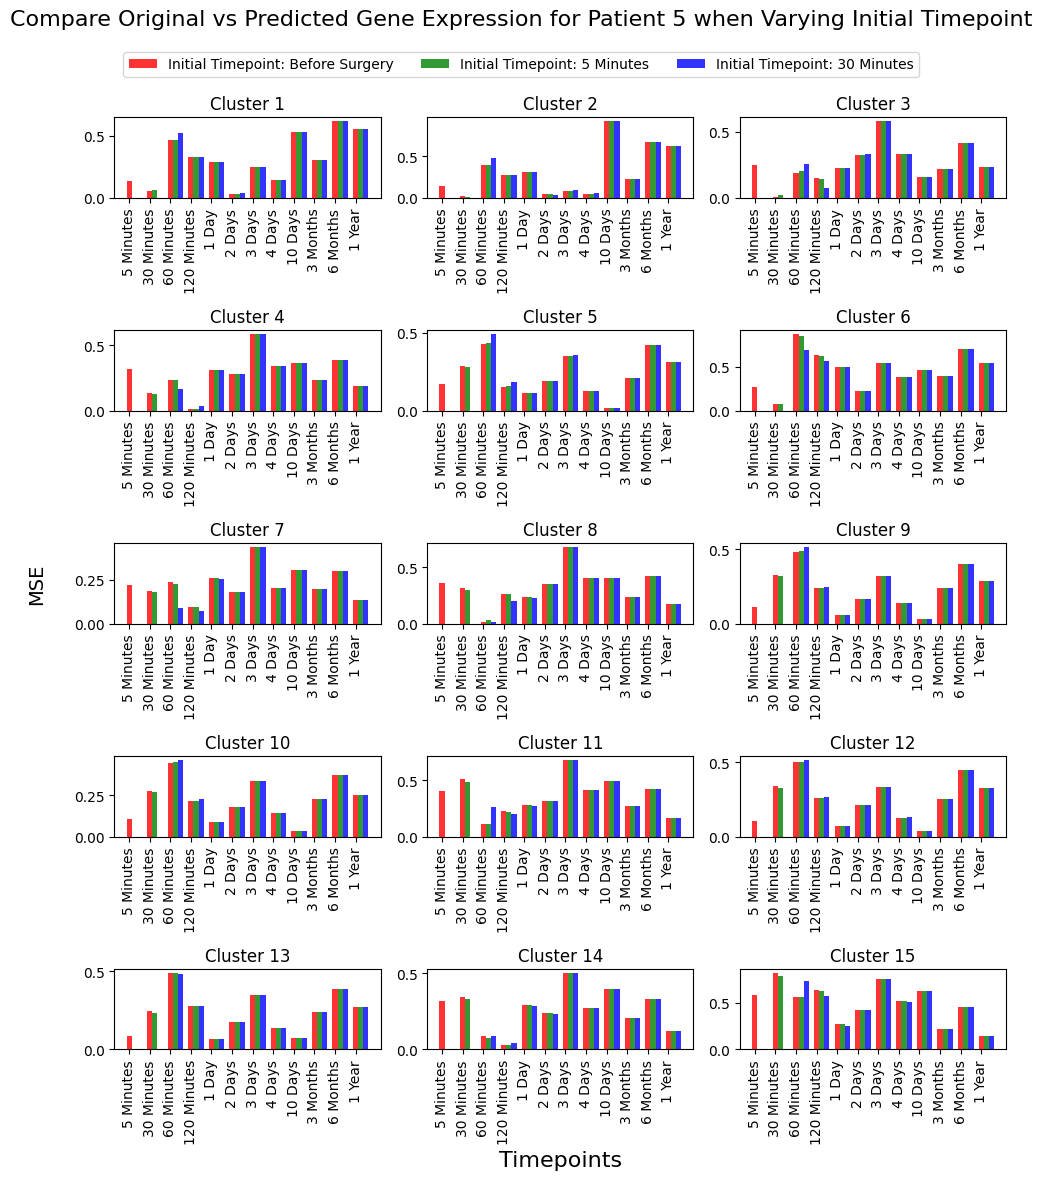

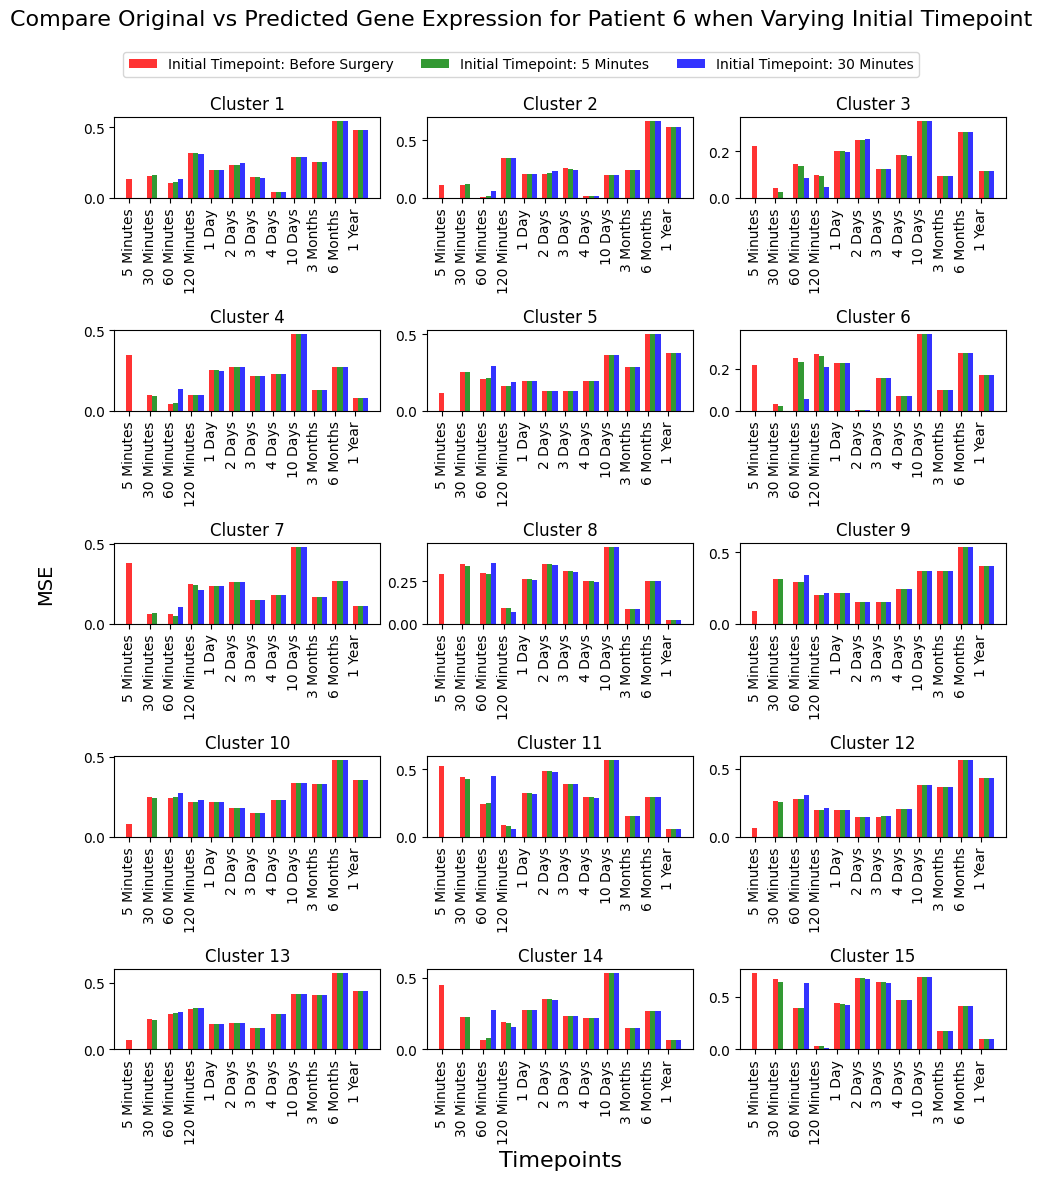

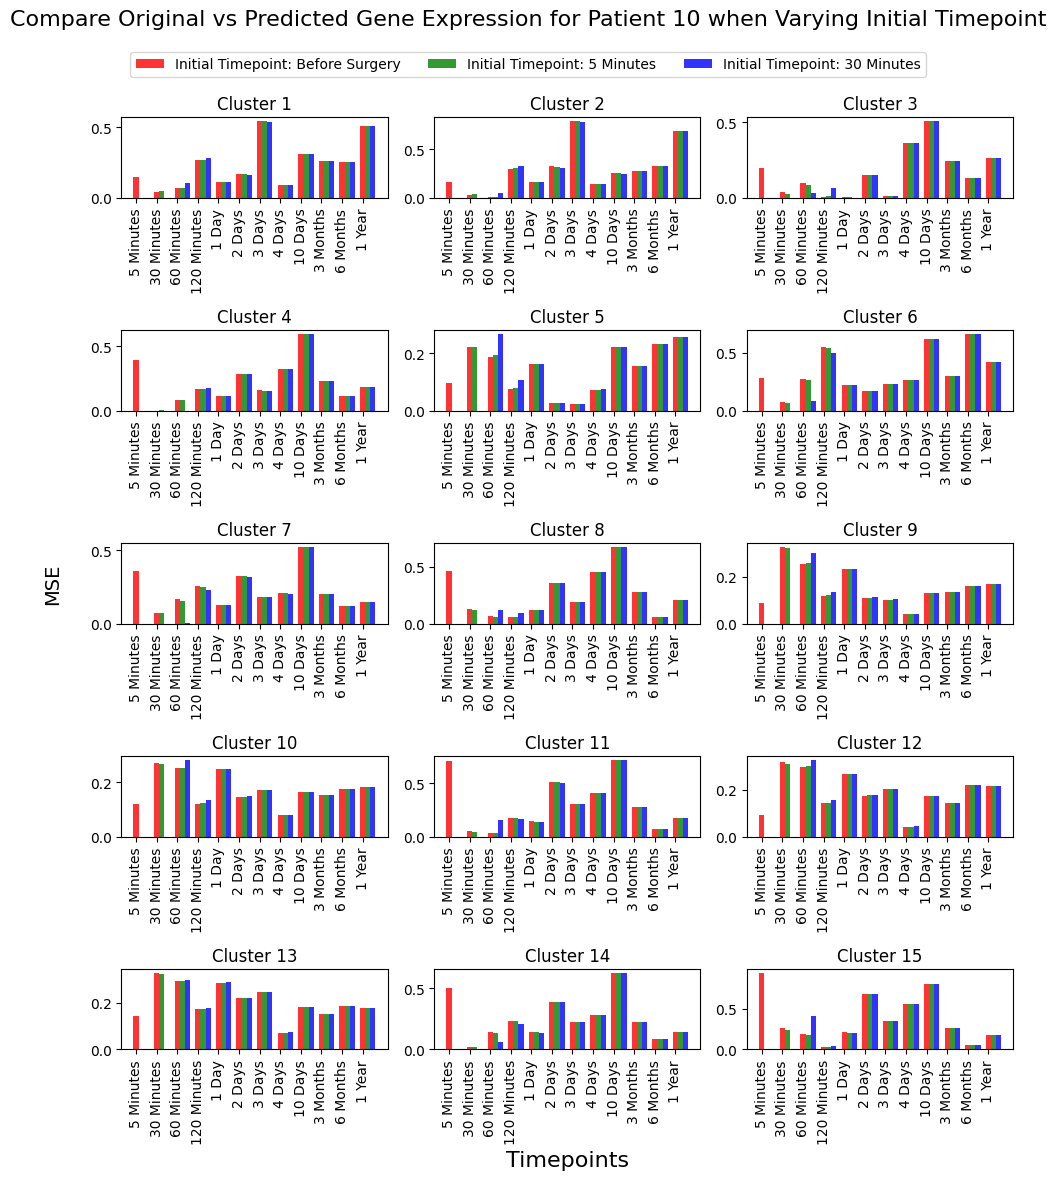

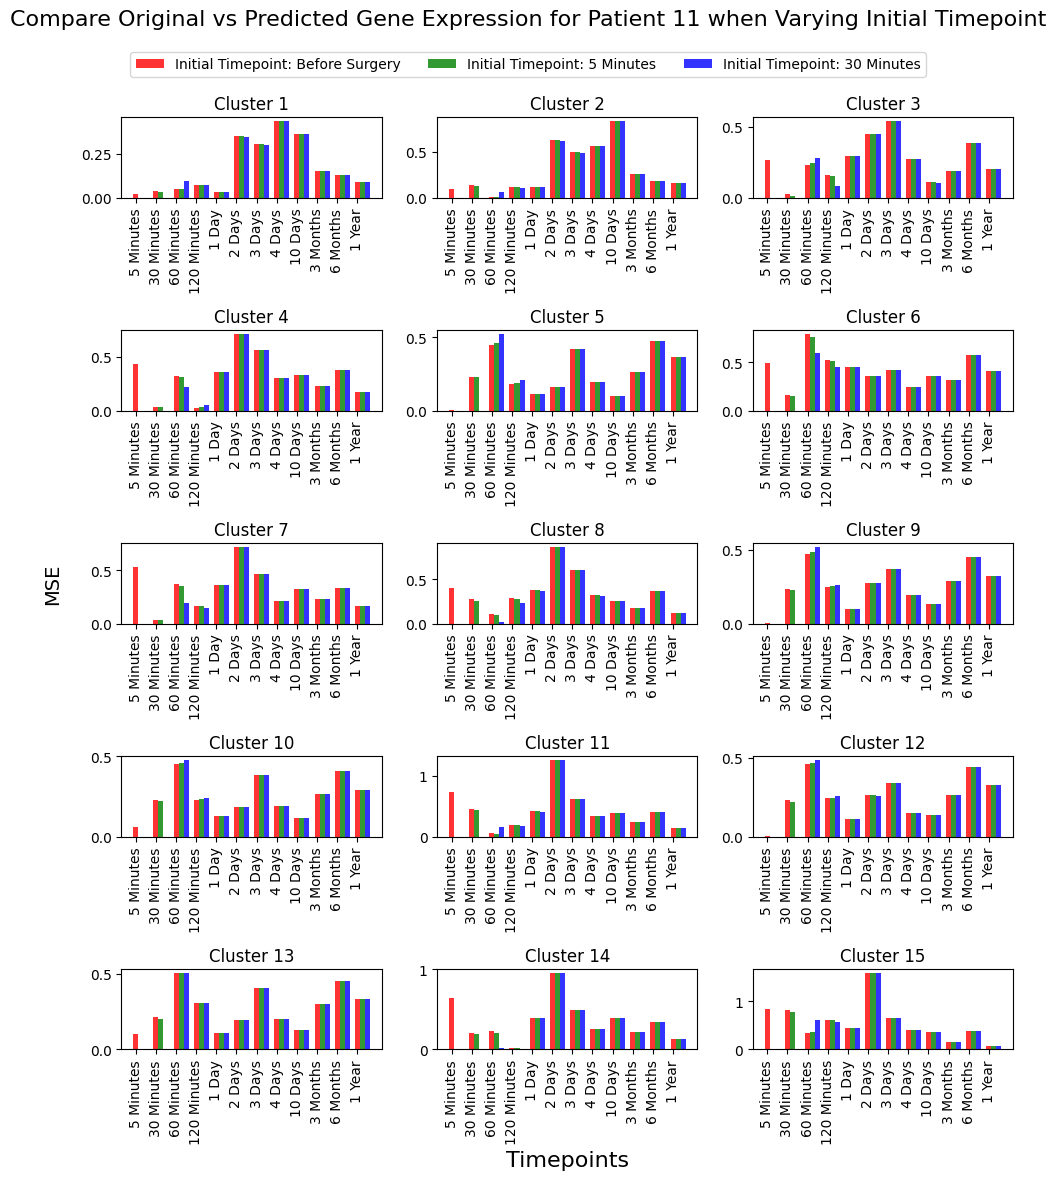

In [186]:

# Loop through each patient
for patient_id in test_patients:
    row_data = test_patient_row_data[patient_id]

    # Define colors for the bars (one for each row)
    colors = ['red', 'green', 'blue']

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(5, 3, figsize=(10, 12))  # Adjusted figure size
    axes = axes.flatten()  # Flatten for easier access to individual subplots

    # Set a title for the entire figure
    fig.suptitle(f"Compare Original vs Predicted Gene Expression for Patient {patient_id} when Varying Initial Timepoint", fontsize=16)


    # Bar width and offset for side-by-side bars
    bar_width = 0.25
    offset = 1  # Adjusted offset for better centering

    # Loop through each cluster and plot in the respective subplot
    for cluster_idx in range(num_clusters):
        ax = axes[cluster_idx]
    
        # Extract the errors corresponding to this cluster (from the 3 rows)
        cluster_data = [entry['errors'] for entry in row_data if entry['cluster_idx'] == cluster_idx]

        # Loop through the three rows of errors and plot bars for each row
        for row_idx, errors in enumerate(cluster_data):
            x_pos = np.arange(len(errors))  # Create x positions for each timepoint
            # print(x_pos)
            # print(row_idx)
            # print(x_pos + row_idx * (bar_width + offset))

            # Plot the bars with different colors for each row
            ax.bar(x_pos + row_idx * (bar_width + offset), errors, width=bar_width, label=f'Initial Timepoint: {timepoint_names[row_idx]}', color=colors[row_idx], alpha=0.8)

        # Set title for each subplot
        ax.set_title(f'Cluster {cluster_idx + 1}')
    
        # Set x-axis labels only for the last two subplots
        if cluster_idx == 13:  # Last two subplots (9th and 10th)
            ax.set_xlabel('Timepoints', fontsize=16)
        else:
            ax.set_xticks([])  # Remove x-ticks for other subplots

        # Set y-axis label only for the 4th subplot
        if cluster_idx == 6:  # 4th subplot (index starts at 0)
            ax.set_ylabel('MSE\n', fontsize=14)

        # Adjust x-ticks to match the number of timepoints in each row
        ax.set_xticks(np.arange(max(len(errors) for errors in cluster_data)))
        ax.set_xticklabels(timepoint_names[1:], rotation=90)

    # Add legend outside the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate legend

    # Save the figure with the appropriate filename and 600 dpi
    filename = f"patient_{patient_id}_error_bars.jpeg"
    fig.savefig(filename, dpi=300)

    plt.show()

   

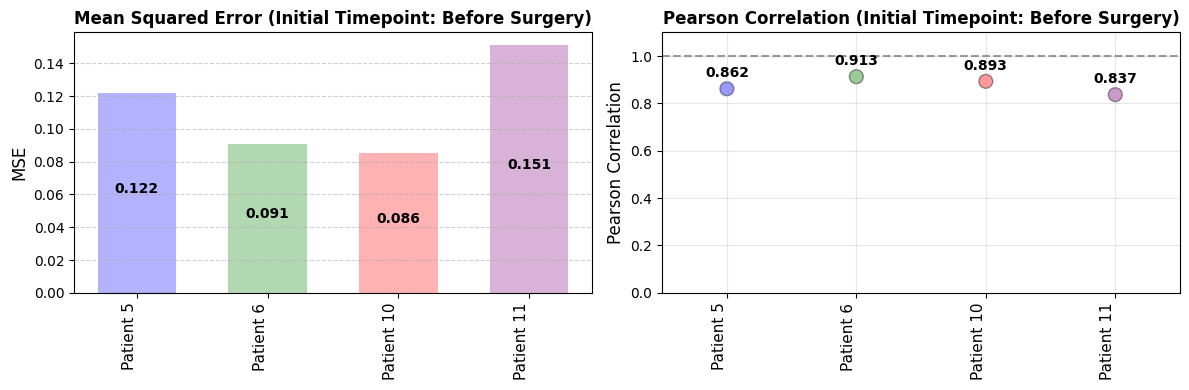

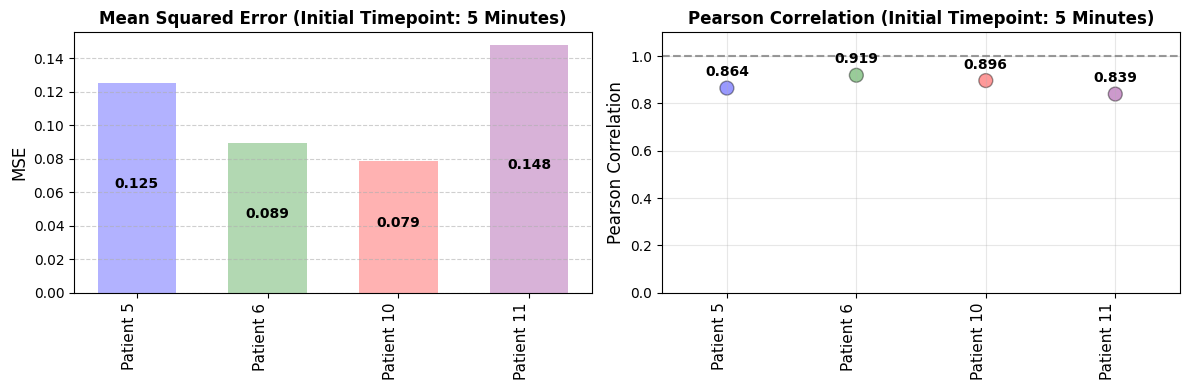

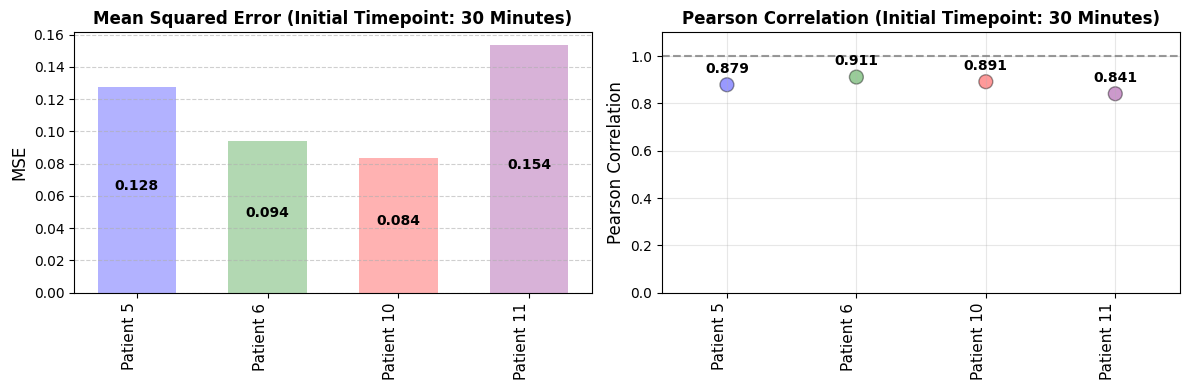

In [156]:

from scipy.stats import pearsonr

num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Store MSE and Pearson correlation for each patient
mse_values = {}
pearson_values = {}

# Define colors for patients
patient_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Loop through each initial timepoint
for initial_timepoint in initial_timepoints:
    mse_list = []
    pearson_list = []
    patient_labels = []
    
    # Define the future timepoints for comparison
    future_timepoints = np.arange(initial_timepoint + 1, num_timepoints)  # Future predictions
    
    # Loop through each patient
    for idx, patient_id in enumerate(test_patients):
        # Retrieve data for the patient and initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        # Original data (select future timepoints)
        original_mean1 = mean_data[patient_id]
        original_mean = np.array(original_mean1)[:, future_timepoints]  # Shape: (num_clusters, future_timepoints)

        # Predicted data (already corresponds to future timepoints)
        mean_values = np.array(data["mean"])  # Shape: (num_clusters, predicted_timepoints)
        predicted_mean = mean_values[:, :len(future_timepoints)]  # Ensure correct slicing

        # Compute MSE and Pearson correlation per cluster
        mse_per_cluster = np.mean((original_mean - predicted_mean) ** 2, axis=1)  # Per cluster
        mse = np.mean(mse_per_cluster)  # Average across clusters
        mse_list.append(mse)

        # Compute Pearson correlation per cluster
        pearson_per_cluster = [
            pearsonr(original_mean[cl], predicted_mean[cl])[0] for cl in range(original_mean.shape[0])
        ]
        pearson = np.mean(pearson_per_cluster)  # Average across clusters
        pearson_list.append(pearson)

        # Store patient label
        patient_labels.append(f"Patient {patient_id}")

    # Store values for plotting
    mse_values[initial_timepoint] = mse_list
    pearson_values[initial_timepoint] = pearson_list

    # Plot MSE and Pearson Correlation
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # **Bar plot for MSE**
    bars = axes[0].bar(patient_labels, mse_list, width=0.6, color=patient_colors[:len(patient_labels)], alpha=0.3)
    axes[0].set_title(f"Mean Squared Error (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("MSE", fontsize=12)
    axes[0].set_xticks(range(len(patient_labels)))  
    axes[0].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    # **Add values on top of bars**
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height - (height/2), f'{height:.3f}', ha='center', fontsize=10, fontweight='bold')

    # **Scatter plot for Pearson Correlation**
    axes[1].scatter(range(len(patient_labels)), pearson_list, color=patient_colors[:len(patient_labels)], s=100, edgecolors='black', alpha=0.4)
    axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.8)  # Reference line at r = 1
    axes[1].set_xlim(-0.5, len(patient_labels) - 0.5)  # This will tighten the spacing between points
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title(f"Pearson Correlation (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Pearson Correlation", fontsize=12)
    axes[1].set_xticks(range(len(patient_labels)))
    axes[1].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[1].grid(alpha=0.3)

    # **Add values on top of scatter points**
    for i, txt in enumerate(pearson_list):
        axes[1].text(i, pearson_list[i] + 0.05, f'{txt:.3f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()

    # Save the figure with the appropriate filename and 600 dpi
    filename = f"MSE_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg"
    fig.savefig(filename, dpi=300)
    
    plt.show()


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load missing timepoints data
missing_df = pd.read_excel("missing_timepoints.xlsx")

# Extract patient numbers and missing timepoints (skip first column)
patients_missing_data = missing_df.set_index(missing_df.columns[0]).iloc[:, 1:].to_numpy()

# Convert to a dictionary for easy lookup
missing_dict = {patient: missing for patient, missing in zip(range(1, 13), patients_missing_data)}


In [164]:
print(missing_dict)

{1: array([ 2,  3,  4,  5,  6,  7,  8,  9,  0, 11,  0, 13, 14]), 2: array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0]), 3: array([ 2,  3,  4,  5,  0,  7,  8,  9,  0, 11, 12, 13, 14]), 4: array([ 2,  3,  4,  5,  0,  7,  8,  0,  0, 11,  0,  0, 14]), 5: array([ 2,  3,  4,  0,  0,  7,  8,  0,  0, 11,  0,  0,  0]), 6: array([2, 3, 4, 5, 0, 7, 8, 9, 0, 0, 0, 0, 0]), 7: array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0]), 8: array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0]), 9: array([ 2,  3,  4,  5,  0,  7,  8,  0,  0, 11,  0, 13, 14]), 10: array([ 2,  3,  4,  5,  0,  7,  8,  9,  0,  0,  0, 13,  0]), 11: array([ 2,  3,  4,  0,  0,  7,  8,  0,  0, 11,  0,  0,  0]), 12: array([ 2,  3,  4,  0,  0,  7,  8,  9, 10, 11, 12, 13, 14])}


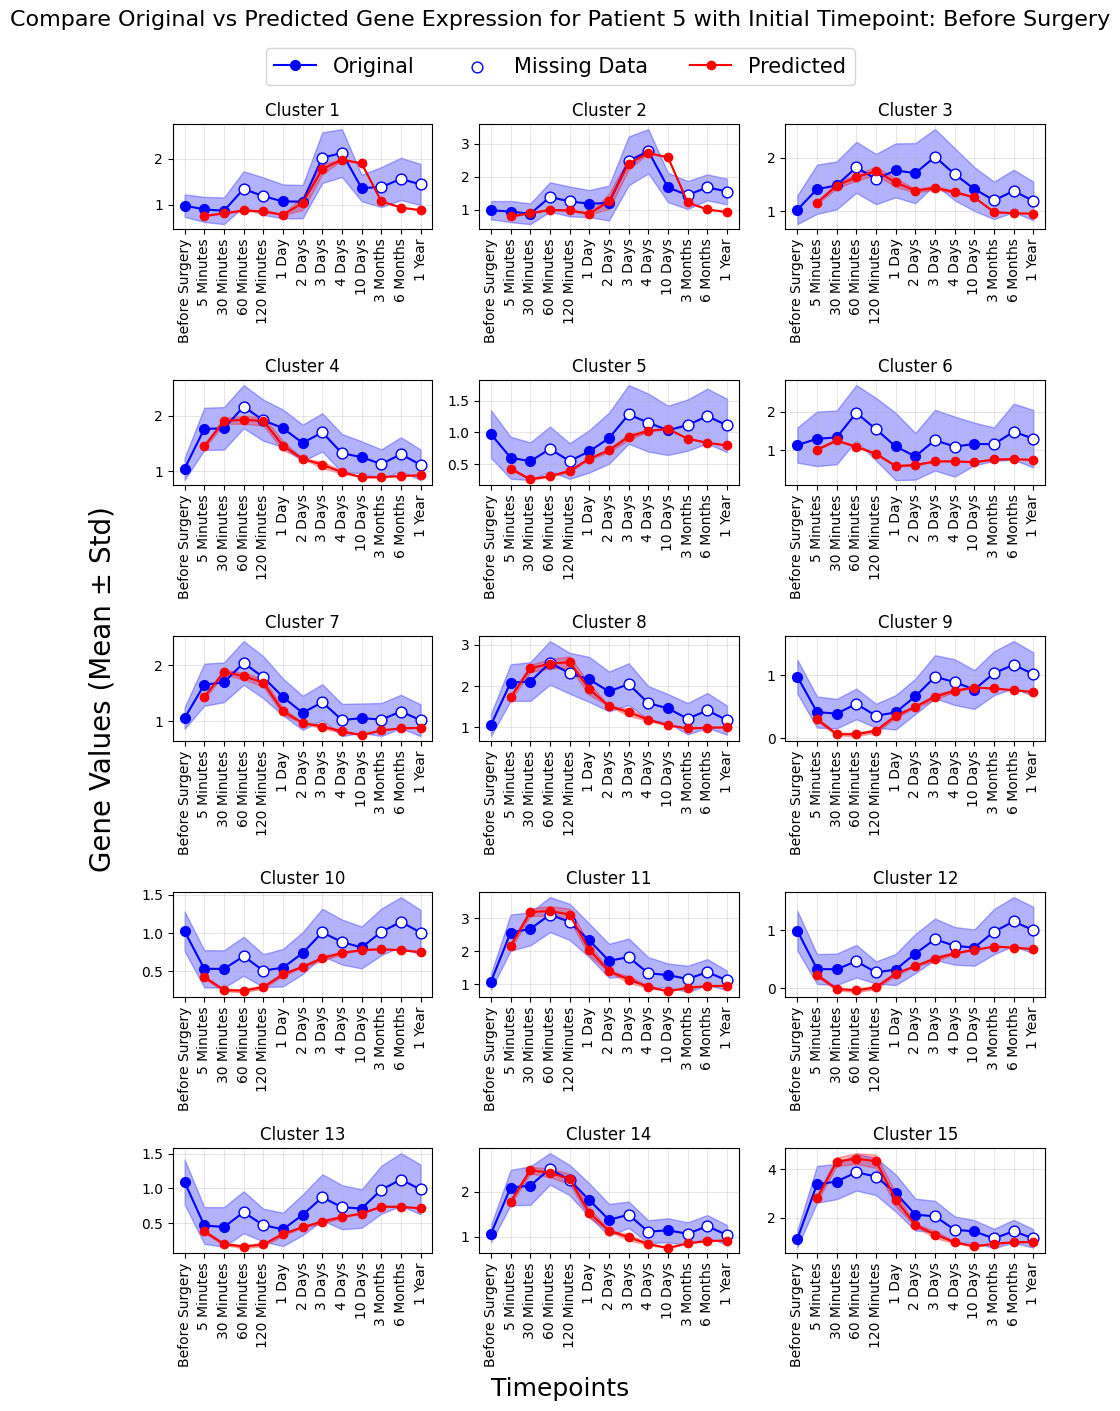

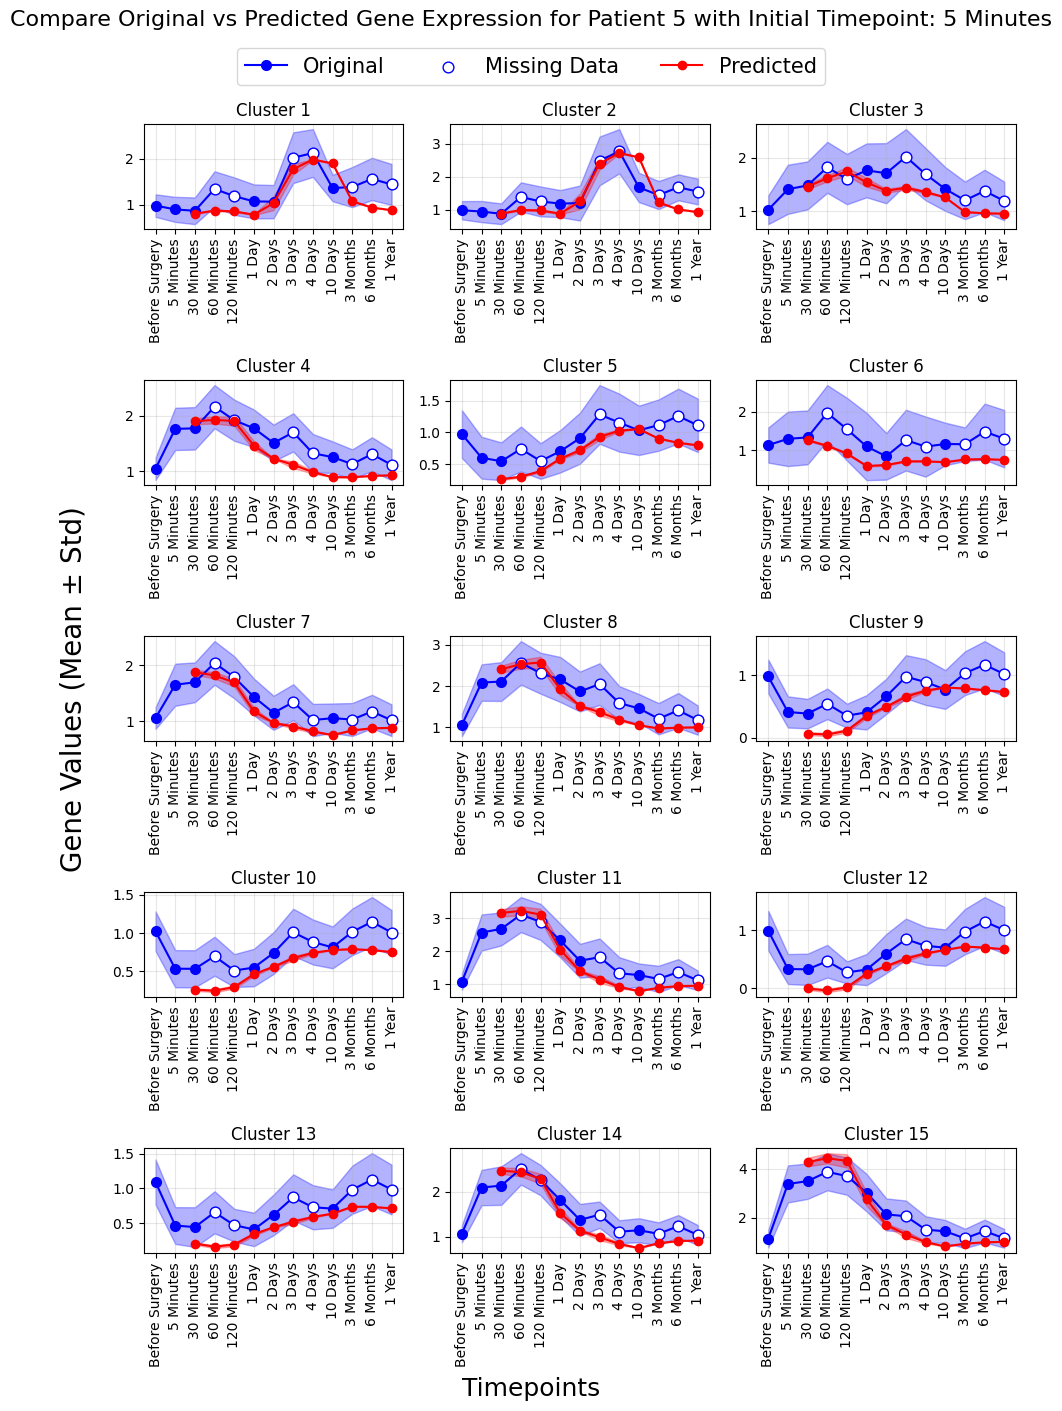

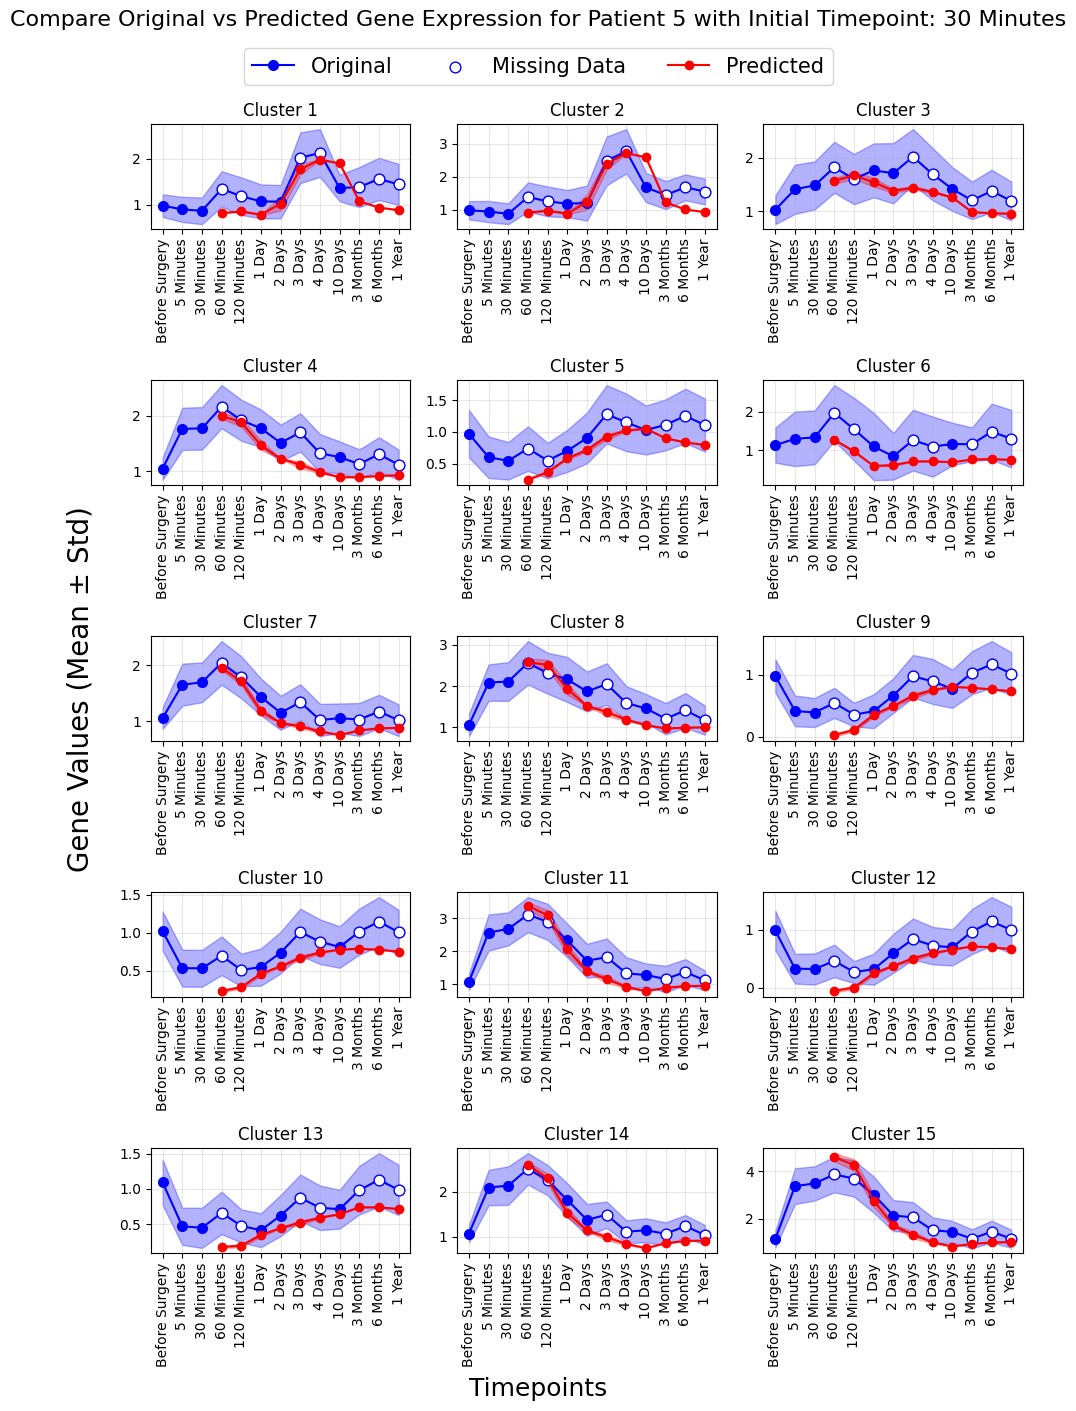

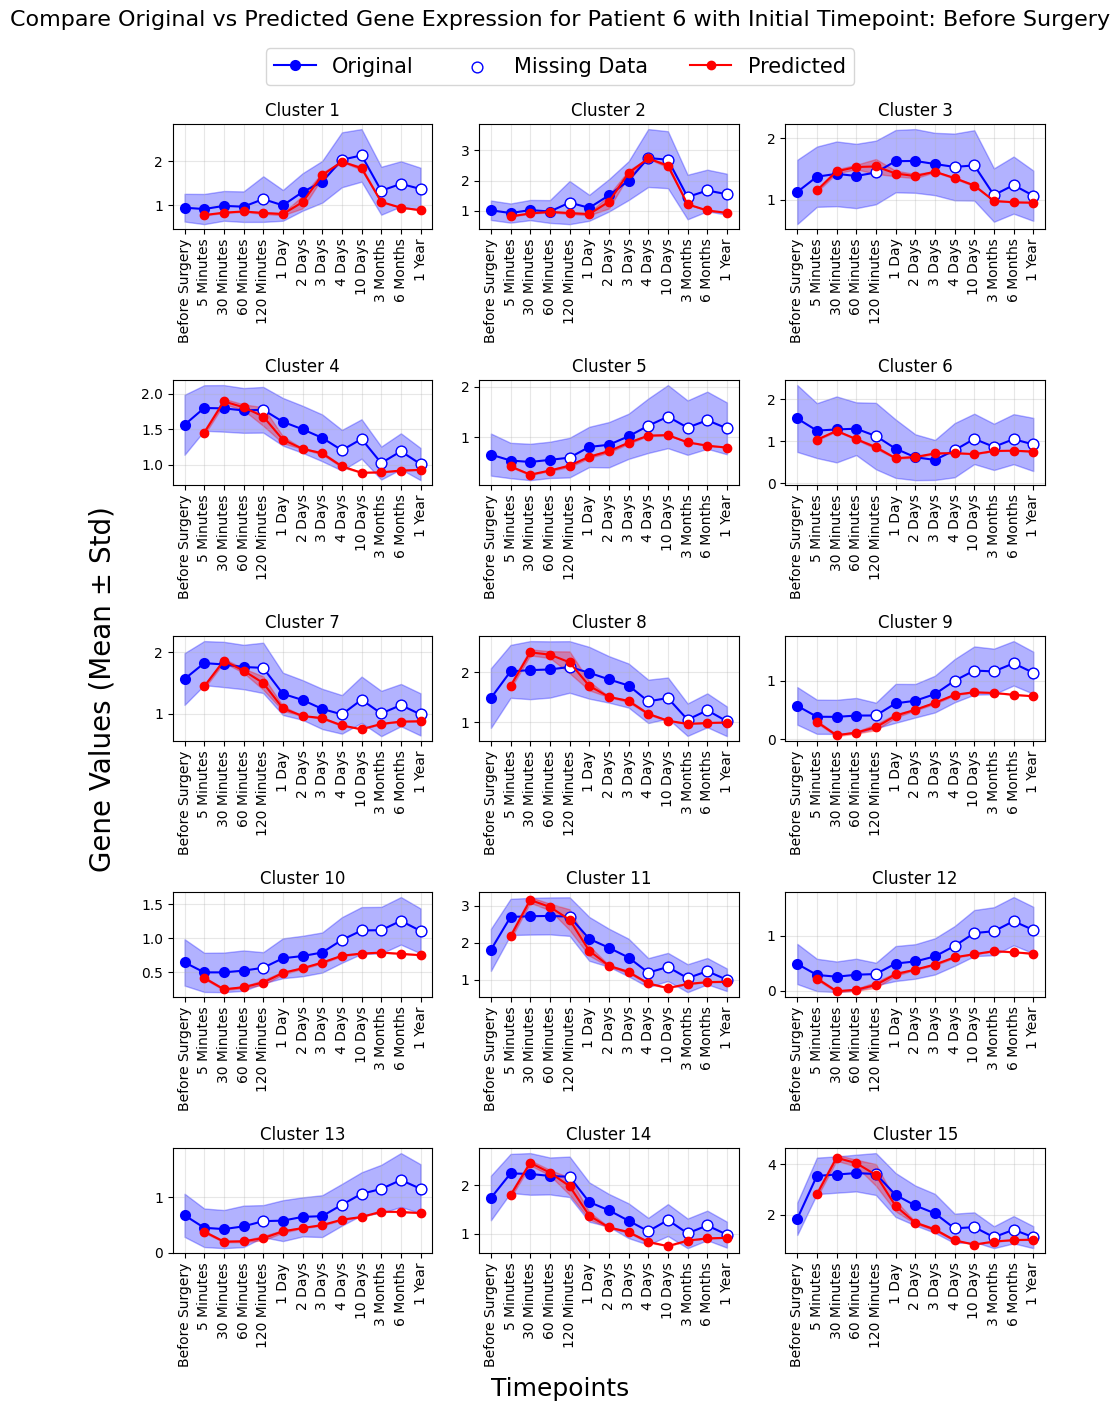

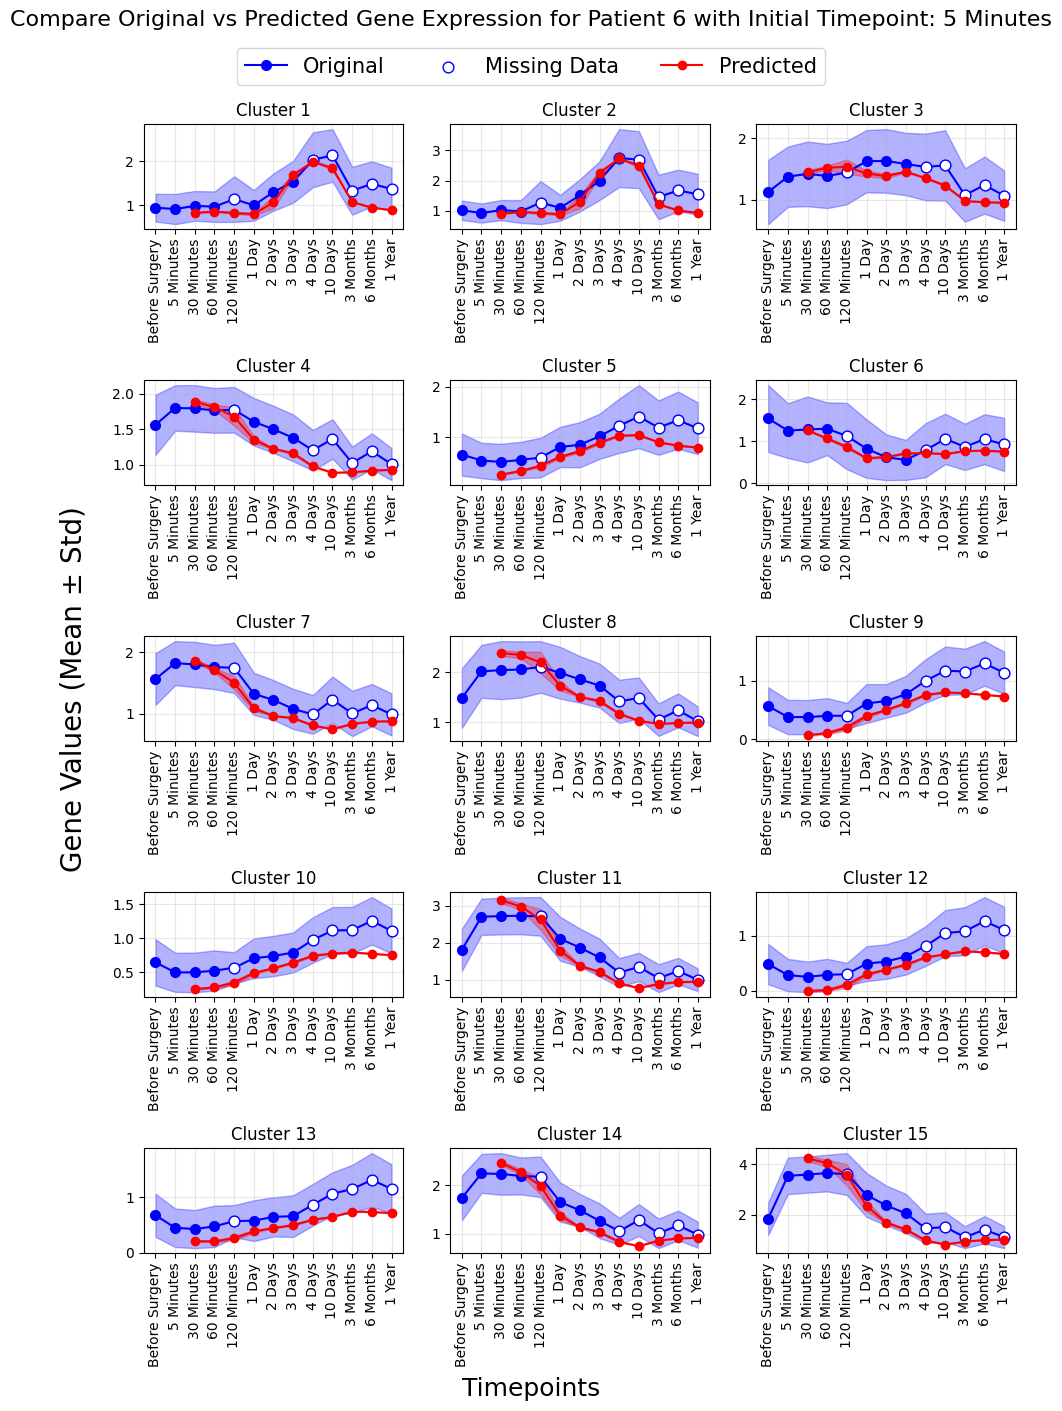

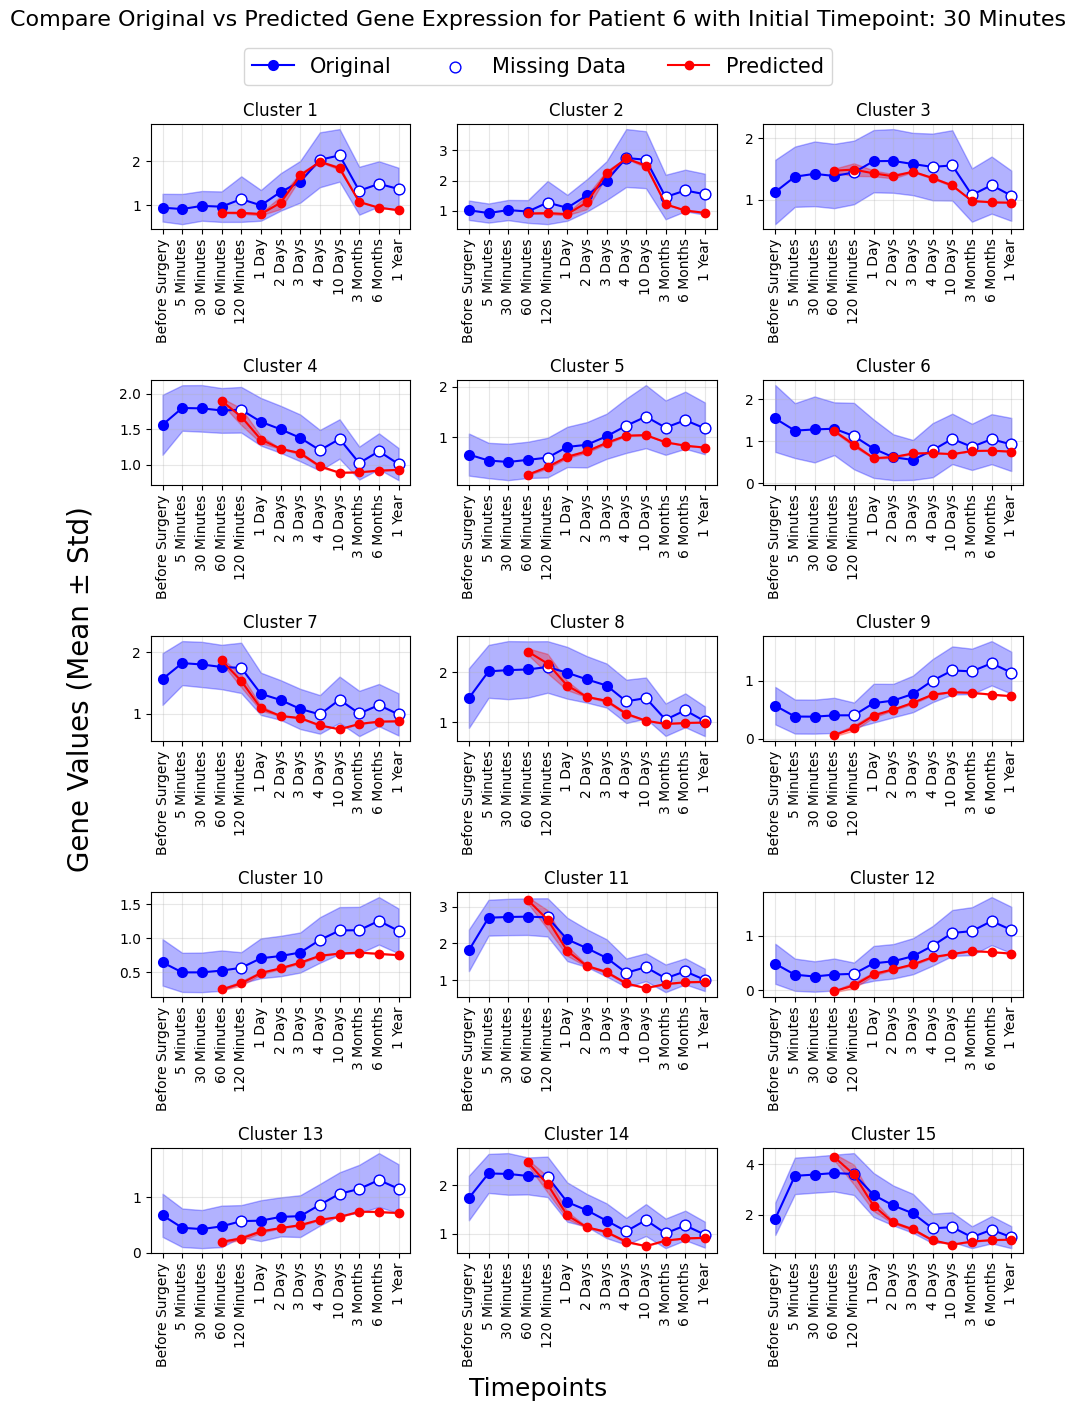

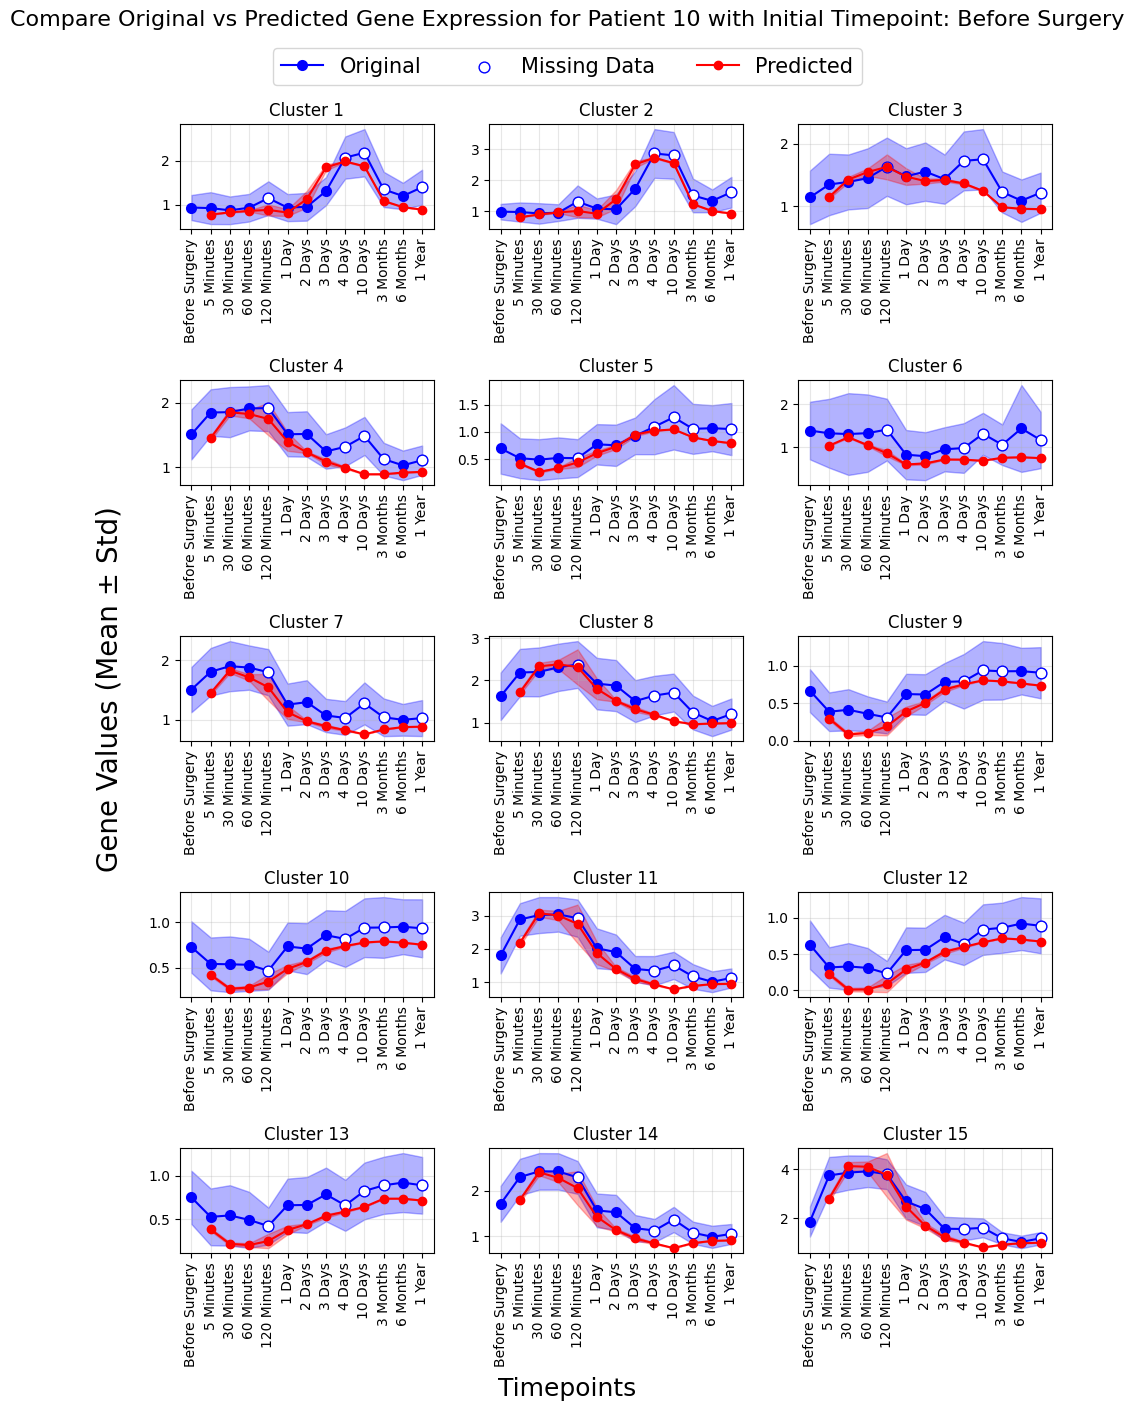

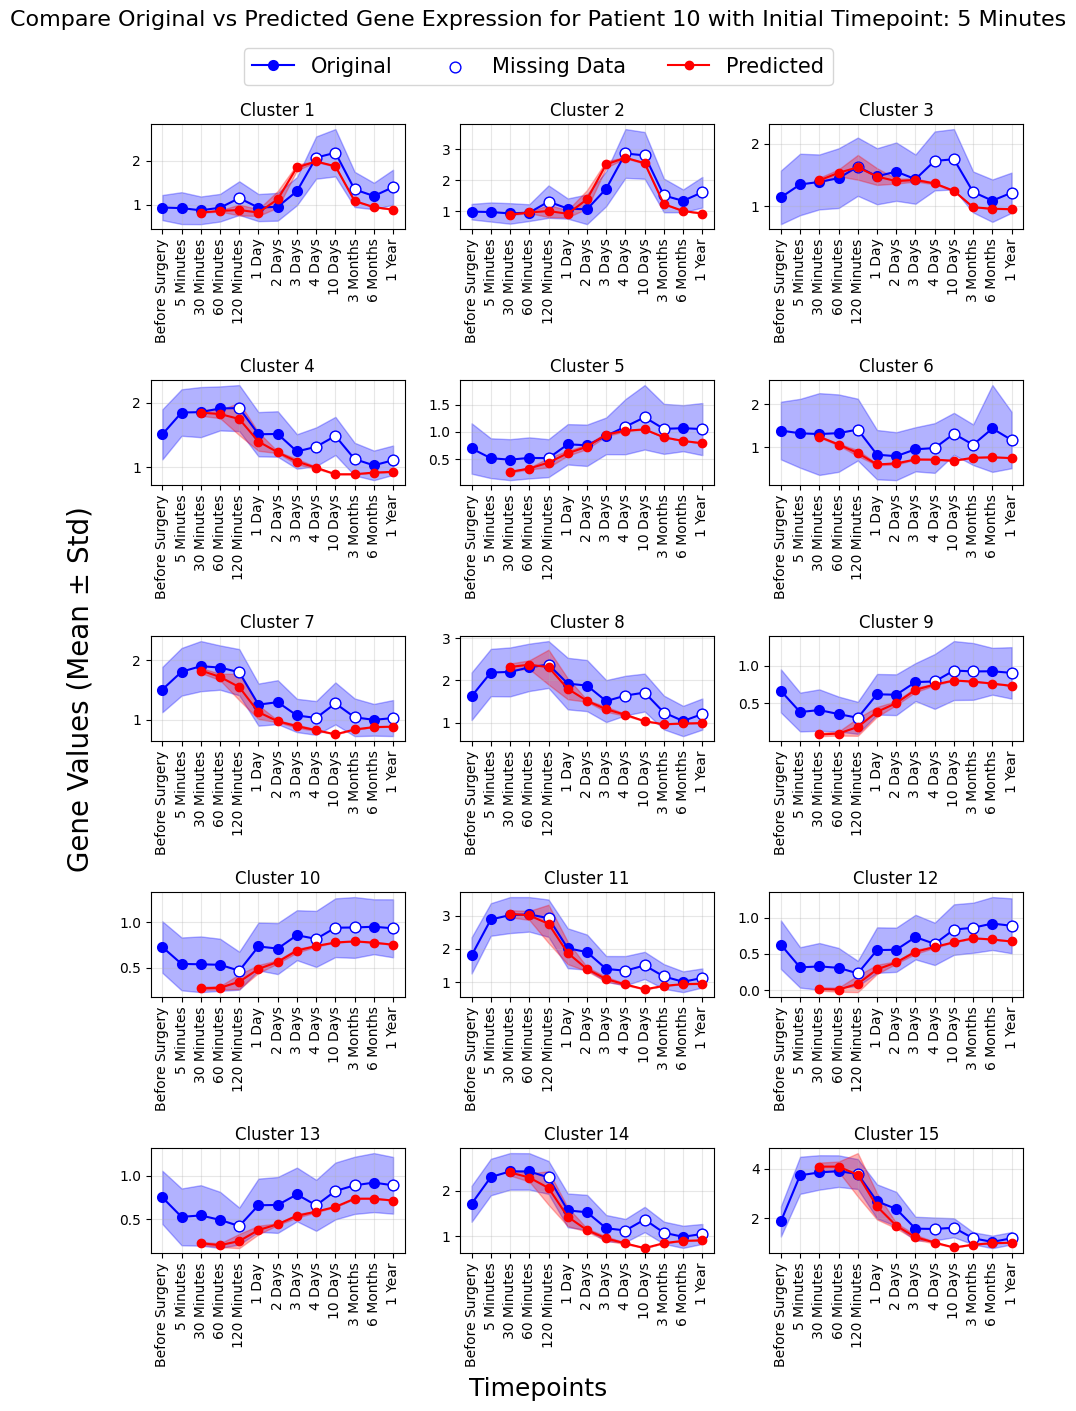

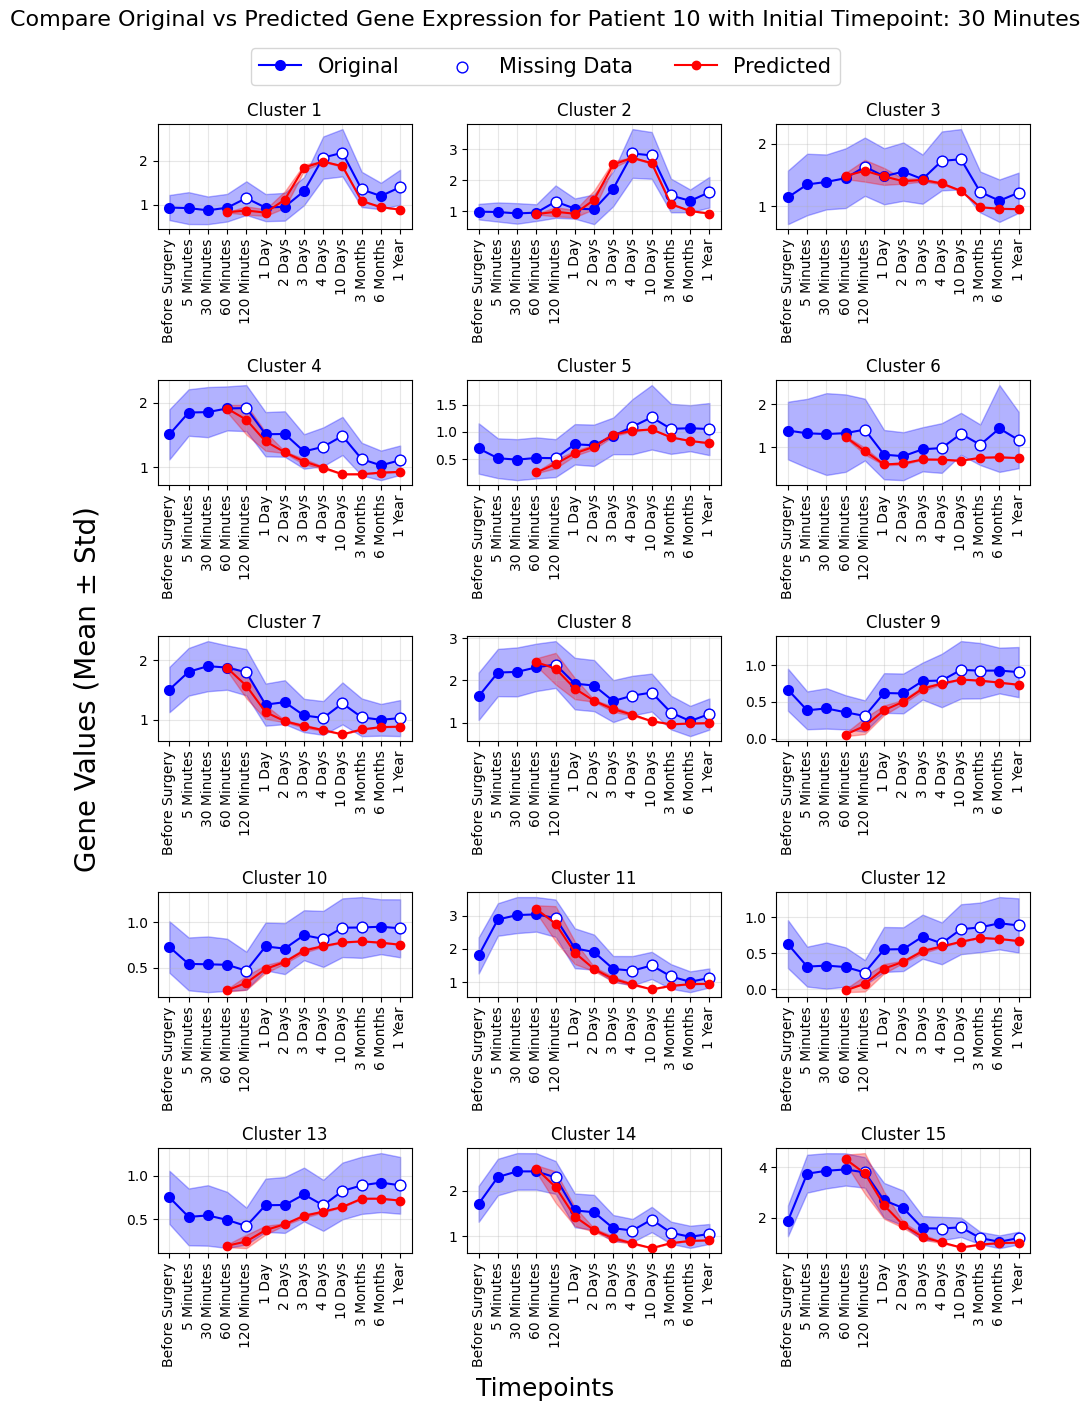

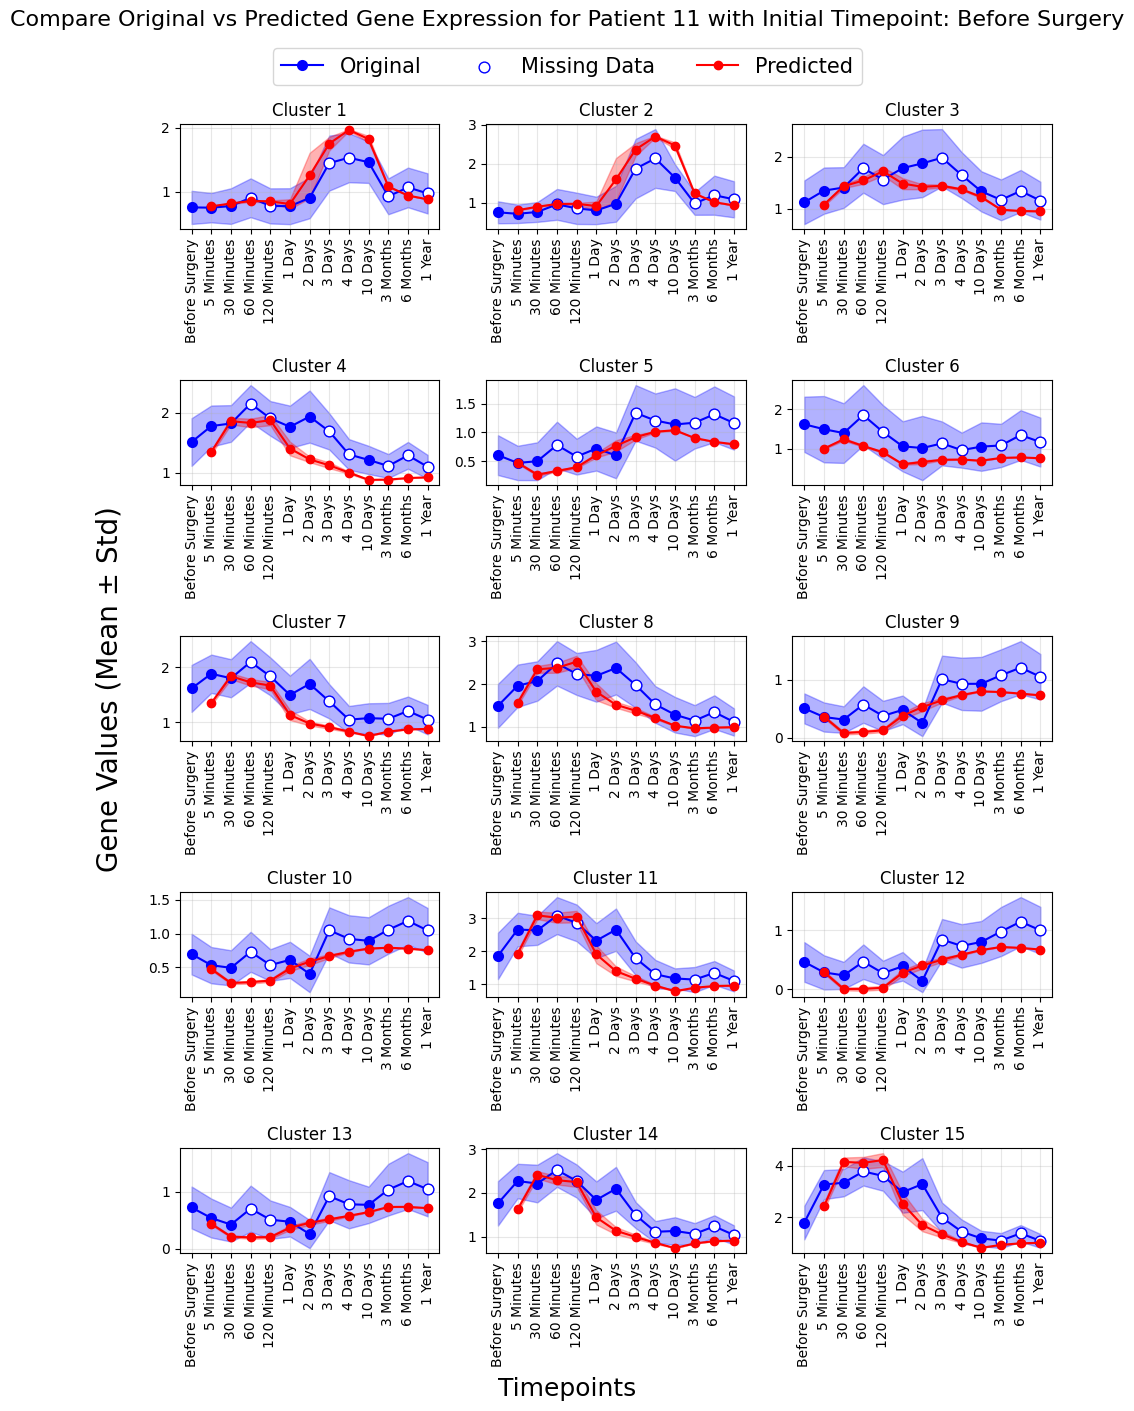

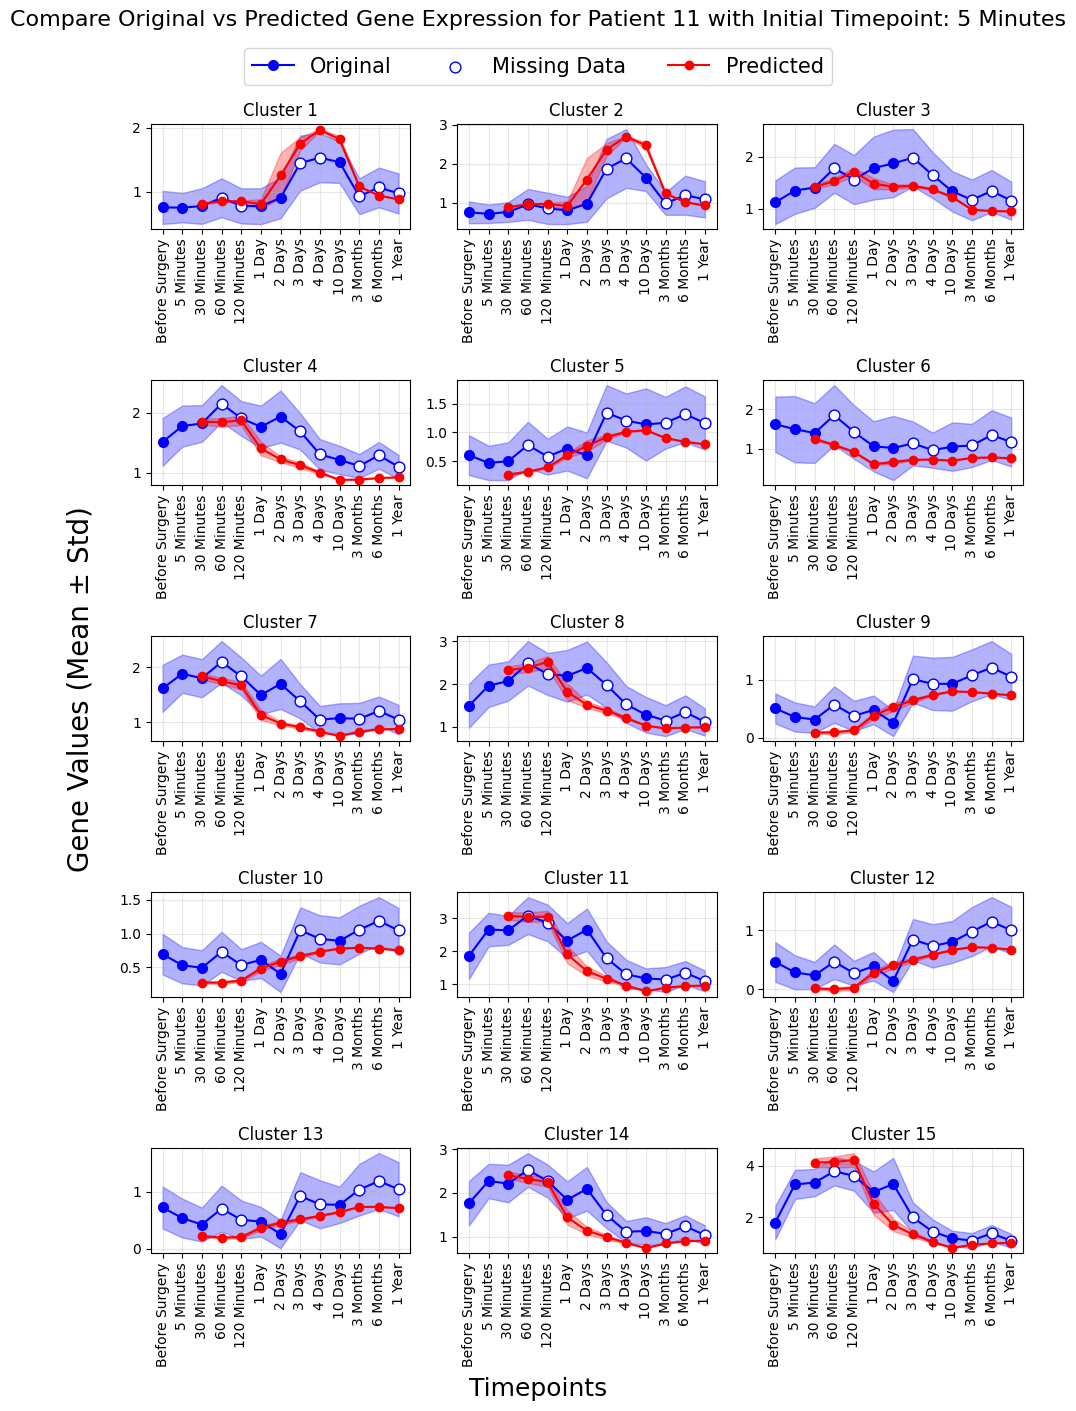

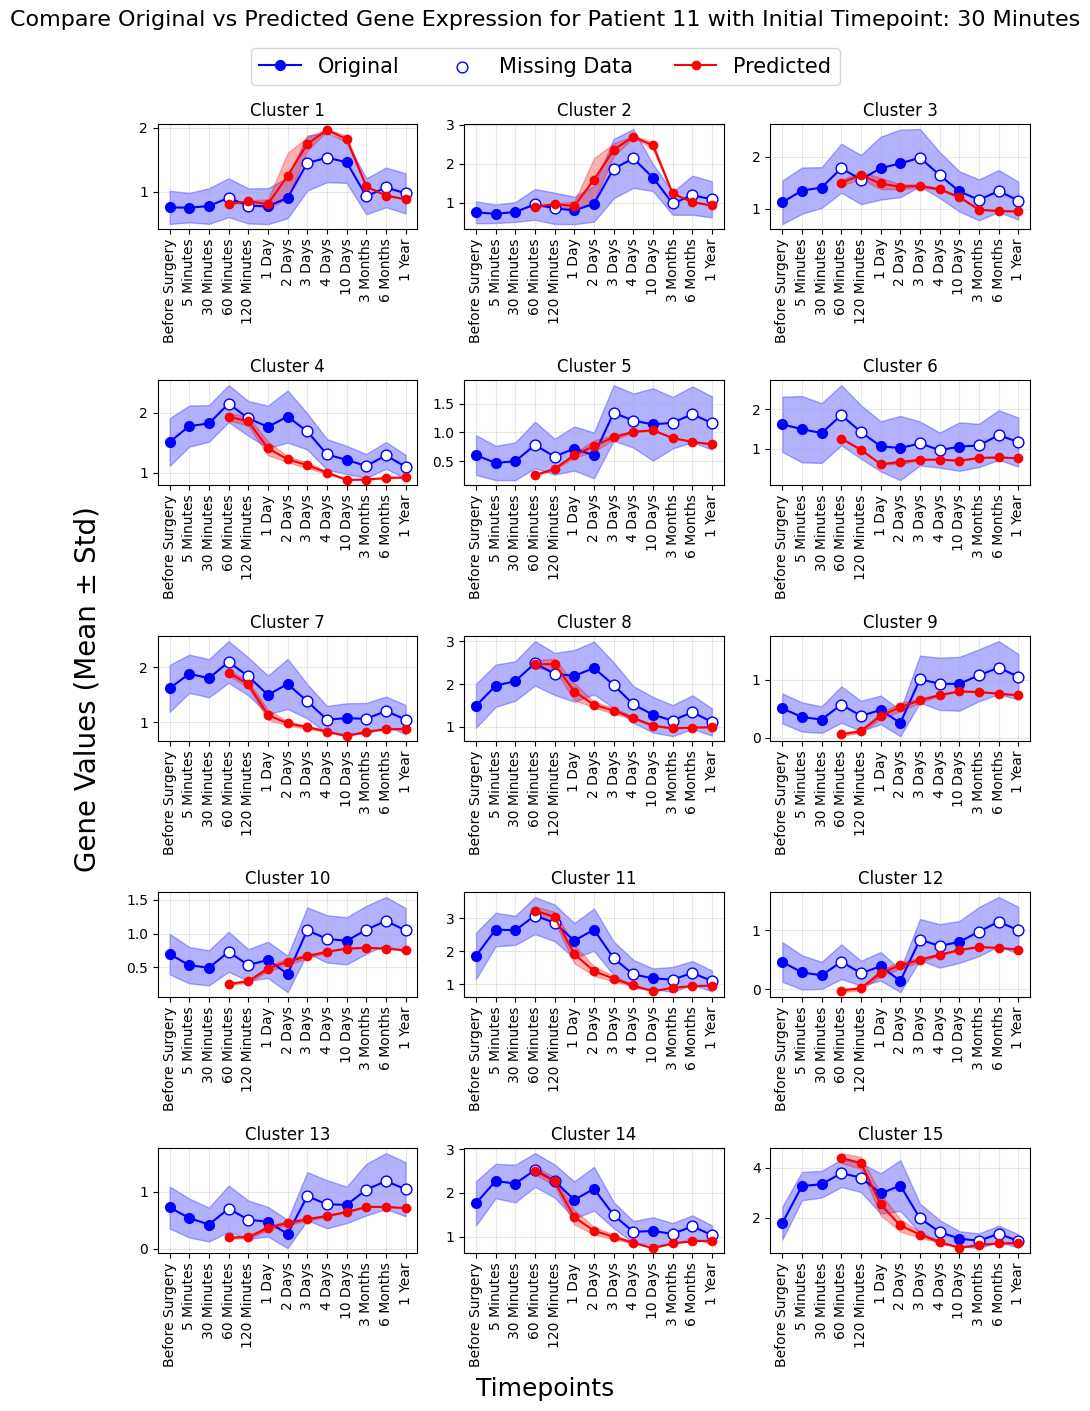

In [182]:
# ================================================================================================
# Plot the mean and standard deviation of gene values: original vs predicted data (using patches)
# ================================================================================================

# Define the timepoint column name based on the timepoint index
num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Loop through each patient
for patient_id in test_patients:
    
    # Loop through each initial timepoint
    for initial_timepoint in initial_timepoints:
        # Process data for the specific initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        timepoint_values_p = np.arange(initial_timepoint + 1, 13)  # Prediction is always the next timepoint
        
        # Select specific timepoint names based on index
        timepoint_names_o = [timepoint_names[i] for i in timepoint_values]
        timepoint_names_p = [timepoint_names[i] for i in timepoint_values_p]

        # Create a figure and axes for plotting
        fig, axes = plt.subplots(5, 3, figsize=(10, 14))  # Adjusted figure size
        axes = axes.flatten()  # Flatten for easier access to individual subplots

        # Set a title for the entire figure
        fig.suptitle(f"Compare Original vs Predicted Gene Expression for Patient {patient_id} with Initial Timepoint: {timepoint_names[initial_timepoint]}", fontsize=16)

        # Loop through each cluster
        for cluster_idx in range(num_clusters):
            original_mean1 = mean_data[patient_id]
            original_mean = original_mean1[cluster_idx]
            
            original_std1 = std_data[patient_id]
            original_std = original_std1[cluster_idx]

            # Predicted values
            mean_values = np.array(data["mean"])
            predicted_mean = mean_values[cluster_idx]
            
            std_values = np.array(data["std"])
            predicted_std = std_values[cluster_idx]

            # Identify missing timepoints for this patient
            missing_mask = np.array(missing_dict[patient_id][0:]) == 0  # Start from the 2nd column

            # Plot the original data (Available: Filled, Missing: Empty)
            axes[cluster_idx].fill_between(timepoint_names_o, 
                                           original_mean - original_std, 
                                           original_mean + original_std, 
                                           color='blue', alpha=0.3, zorder=1)  # Keep shaded area behind everything
            axes[cluster_idx].plot(timepoint_names_o, original_mean, '-o', color='blue', label="Original",
                                   markerfacecolor='blue', markeredgewidth=2, zorder=2)  # Ensure original line is above shaded area

            # Mark missing data with empty markers (Plotted Last)
            axes[cluster_idx].scatter(np.array(timepoint_names_o)[missing_mask], original_mean[missing_mask],
                                      edgecolor='blue', facecolor='white', s=60, label="Missing Data", zorder=2)  # Higher zorder for visibility

            # Plot the predicted data
            axes[cluster_idx].plot(timepoint_names_p, predicted_mean, '-o', color='red', label="Predicted", zorder=2)
            axes[cluster_idx].fill_between(timepoint_names_p, 
                                           predicted_mean - predicted_std, 
                                           predicted_mean + predicted_std, 
                                           color='red', alpha=0.3, zorder=1)

            axes[cluster_idx].set_xticks(timepoint_names_o)  
            axes[cluster_idx].set_xticklabels(timepoint_names_o, rotation=90)  
            axes[cluster_idx].set_title(f"Cluster {cluster_idx + 1}", fontsize=12)
            axes[cluster_idx].grid(alpha=0.3)
            if cluster_idx == 6:
                axes[cluster_idx].set_ylabel("Gene Values (Mean ± Std)\n", fontsize=20)

        # Set the x-axis labels across all subplots
        fig.text(0.5, -0.01, 'Timepoints', ha='center', fontsize=18)

        # Add legend outside the figure
        handles, labels = axes[cluster_idx].get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

        # Adjust layout to avoid overlap
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate legend

        # Save the figure with the appropriate filename and 600 dpi
        filename = f"patient_{patient_id}_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg"
        fig.savefig(filename, dpi=300)

        plt.show()


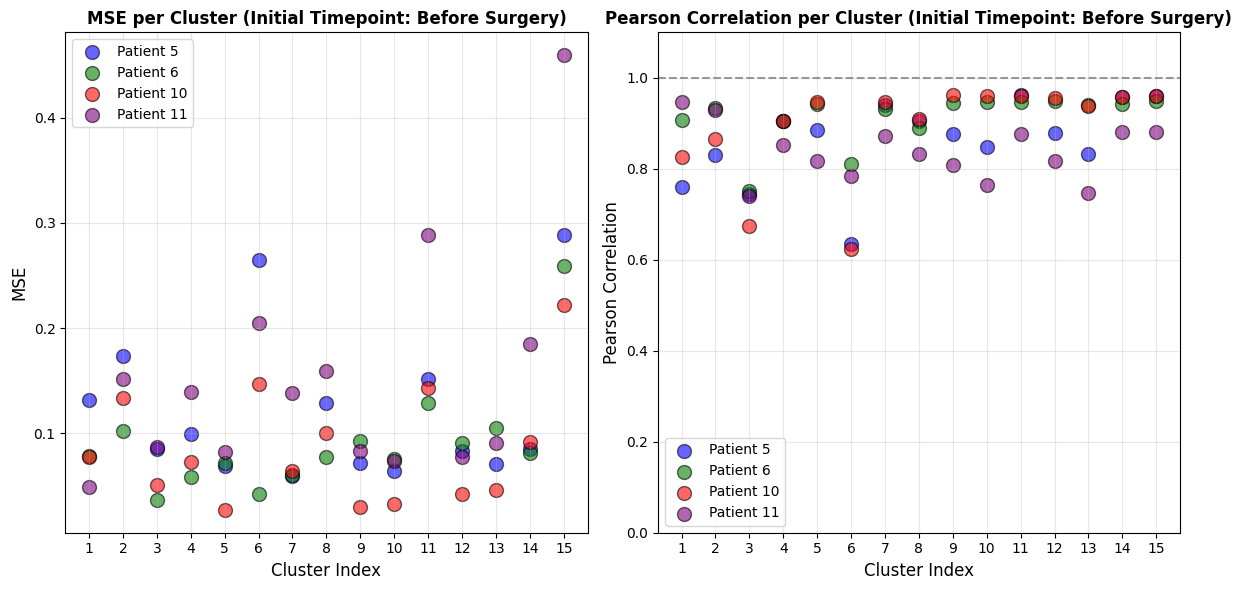

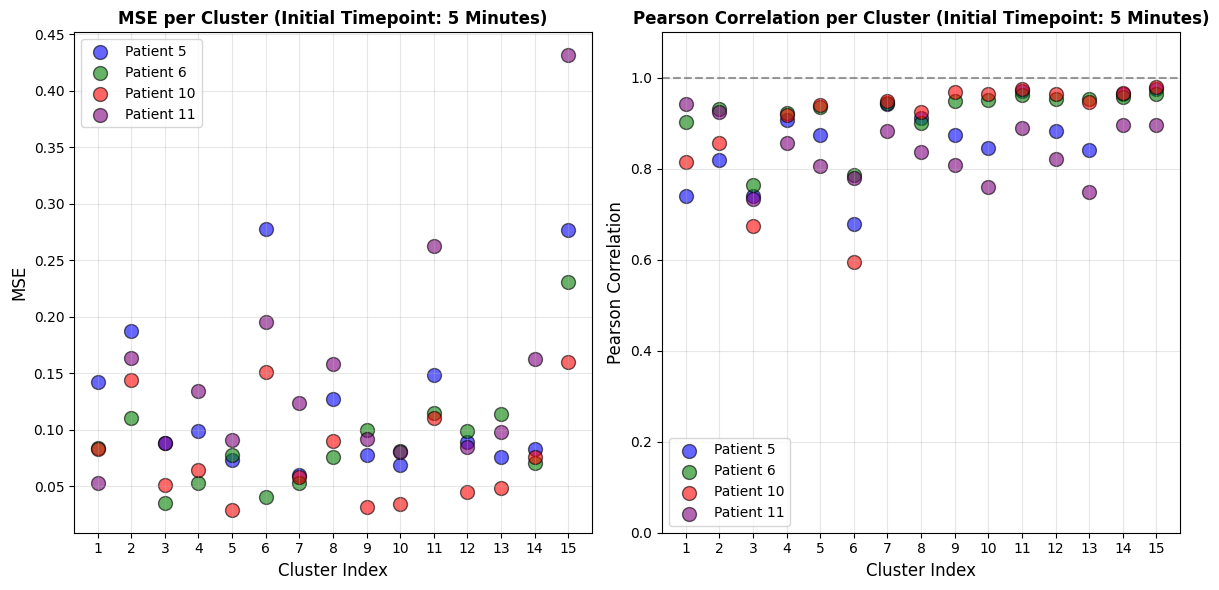

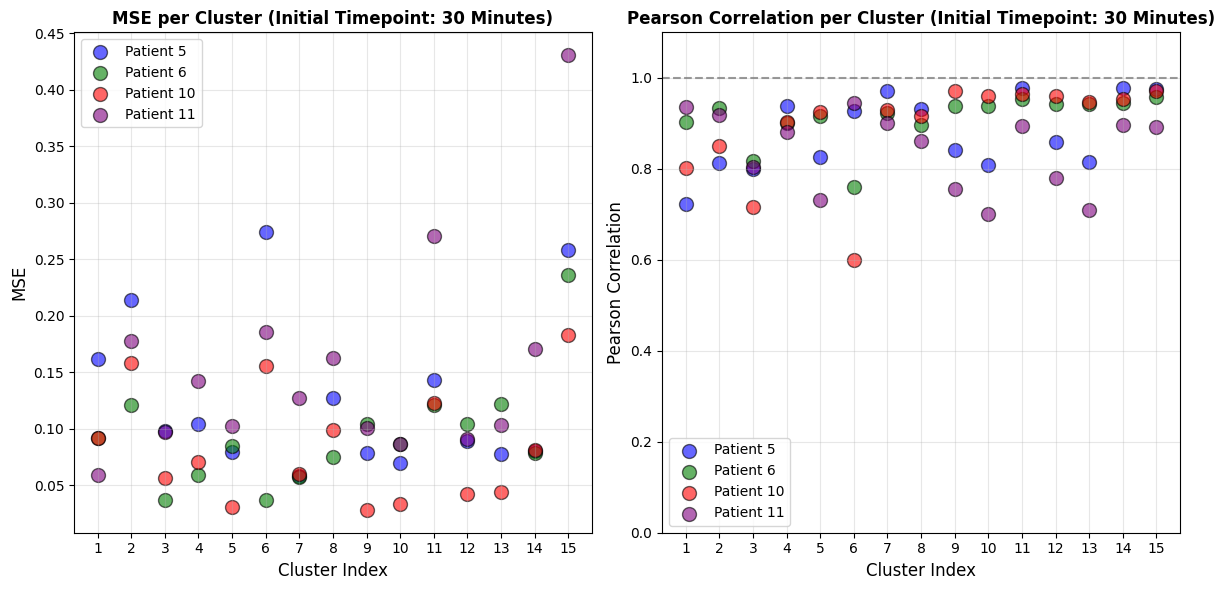

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Store MSE and Pearson correlation for each patient
mse_values = {}
pearson_values = {}

# Define colors for different patients (ensure enough unique colors)
patient_colors = ['blue', 'green', 'red', 'purple']

# Loop through each initial timepoint
for initial_timepoint in initial_timepoints:
    mse_clusters = []
    pearson_clusters = []
    patient_labels = []
    
    future_timepoints = np.arange(initial_timepoint + 1, num_timepoints)  # Future predictions
    
    for idx, patient_id in enumerate(test_patients):
        # Retrieve data for the patient and initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        # Original data (select future timepoints)
        original_mean1 = mean_data[patient_id]
        original_mean = np.array(original_mean1)[:, future_timepoints]  # Shape: (num_clusters, future_timepoints)

        # Predicted data (already corresponds to future timepoints)
        mean_values = np.array(data["mean"])  # Shape: (num_clusters, predicted_timepoints)
        predicted_mean = mean_values[:, :len(future_timepoints)]  # Ensure correct slicing

        # Compute MSE per cluster
        mse_per_cluster = np.mean((original_mean - predicted_mean) ** 2, axis=1)  # Shape: (num_clusters,)
        mse_clusters.append(mse_per_cluster)  # Store MSE per cluster
        
        # Compute Pearson correlation per cluster
        pearson_per_cluster = [
            pearsonr(original_mean[cl], predicted_mean[cl])[0] for cl in range(original_mean.shape[0])
        ]
        pearson_clusters.append(pearson_per_cluster)  # Store Pearson per cluster

        # Store patient label
        patient_labels.append(f"Patient {patient_id}")

    # Convert lists to arrays for easier indexing
    mse_clusters = np.array(mse_clusters)  # Shape: (num_patients, num_clusters)
    pearson_clusters = np.array(pearson_clusters)  # Shape: (num_patients, num_clusters)

    # Create a figure with 1 row and 2 columns for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # **Plot MSE Scatter Plot**
    for idx, patient_id in enumerate(test_patients):
        axes[0].scatter(range(15), mse_clusters[idx], color=patient_colors[idx], label=f"Patient {patient_id}", s=100, alpha=0.6, edgecolors='black')

    axes[0].set_title(f"MSE per Cluster (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Cluster Index", fontsize=12)
    axes[0].set_ylabel("MSE", fontsize=12)
    axes[0].set_xticks(range(15))
    axes[0].set_xticklabels(range(1, 16))  # Display clusters as 1-15
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # **Plot Pearson Correlation Scatter Plot**
    for idx, patient_id in enumerate(test_patients):
        axes[1].scatter(range(15), pearson_clusters[idx], color=patient_colors[idx], label=f"Patient {patient_id}", s=100, alpha=0.6, edgecolors='black')

    axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.8)  # Reference line at r = 1
    axes[1].set_title(f"Pearson Correlation per Cluster (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Cluster Index", fontsize=12)
    axes[1].set_ylabel("Pearson Correlation", fontsize=12)
    axes[1].set_xticks(range(15))
    axes[1].set_xticklabels(range(1, 16))  # Display clusters as 1-15
    axes[1].set_ylim(0, 1.1)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"MSE_Pearson_Clusters_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg", dpi=300)
    plt.show()
